# Exploratory Analysis of the Vinho Verde Dataset

**Context**  
This notebook is the first step of our study on the “Vinho Verde” (Portuguese red wines) dataset from Cortez et al. Each sample was rated on a 0–10 scale by three CRVV evaluators. The main goal is to explore the physicochemical variables to prepare for supervised modeling (regression and classification).

**Instructor Feedback**  
- Clearly define the “story” we will tell during the defense presentation:  
  1. **How do chemical properties influence perceived quality?**  
  2. **What would be the characteristics of an “excellent” wine?**  
  3. **How to predict the numerical quality (regression)?**  
  4. **How to classify a wine as “good” vs. “bad” (binary classification)?**  
- The `quality` variable is discrete (0–10): we can approach it as regression (continuous ordinal) or transform it into a binary/categorical variable for classification (e.g., `quality ≥ 6`).

**Objectives of this Notebook**  
1. Load and type the dataset  
2. Clean, deduplicate, and normalize variables  
3. Perform univariate and bivariate EDA (correlations, visualizations, mathematical/statistical interpretations)  
4. Clarify the choice between regression and classification  
5. Structure the workflow for the next notebooks

**Notebook Outline**  
1. **Preamble & Imports**  
2. **Data Loading & Typing**  
3. **Cleaning & Preprocessing**  
4. **Exploratory Data Analysis (EDA)**  
5. **Problem Definition**  
6. **Summary & Next Steps**


## 1. Preamble & Imports

In [18]:
# Imports
from __future__ import annotations

import os
import sys
from typing import Dict, Any, TypedDict, List, Final
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split

# -----------------------------------------------------------------------------
# Configuration of display settings
# -----------------------------------------------------------------------------
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14
sns.set_theme(context="notebook", style="whitegrid")
%config InlineBackend.figure_format = 'retina'

# -----------------------------------------------------------------------------
# Version checks to ensure compatibility
# -----------------------------------------------------------------------------
assert sys.version_info >= (3, 8), "Python >= 3.8 is required."
print(f"Python version: {sys.version.split()[0]}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")


Python version: 3.13.3
Pandas version: 2.2.3
NumPy version: 2.2.4
Matplotlib version: 3.10.3
Seaborn version: 0.13.2


## 2. Data Loading & Typing

### 2.1 Defining the Data Schema  
We introduce a `TypedDict` to precisely describe each sample’s variables, distinguishing continuous variables (ℝ) from discrete ones (ℤ).

In [19]:
# %% 2.1 Data schema definition

class WineSample(TypedDict):
    fixed_acidity: float            # amount of fixed acids
    volatile_acidity: float         # amount of volatile acids
    citric_acid: float              # citric acid content
    residual_sugar: float           # sugar left after fermentation
    chlorides: float                # salt content
    free_sulfur_dioxide: float      # free SO₂
    total_sulfur_dioxide: float     # total SO₂
    density: float                  # mass per unit volume
    pH: float                       # acidity scale
    sulphates: float                # sulfate content
    alcohol: float                  # ethanol percentage
    quality: int                    # sensory quality score (0–10)
    Id: int                         # unique sample identifier

### 2.2 Loading, Renaming & Casting  
We implement a function to:
1. Load the CSV file.  
2. Rename columns to `snake_case` for Python conventions.  
3. Enforce correct dtypes: floats for continuous measures and integers for discrete labels/IDs.

In [20]:

# %% 2.2 Load, rename and cast dataset

def load_dataset(file_path: str) -> pd.DataFrame:
    """
    Load the Vinho Verde dataset, rename columns to snake_case,
    and enforce theTypedDict schema via dtype casting.

    Parameters:
        file_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: DataFrame with properly typed columns.
    """
    # Load raw CSV
    df: pd.DataFrame = pd.read_csv(file_path)

    # Rename columns to snake_case (PEP 8 convention)
    df.columns = [
        col.strip().lower().replace(" ", "_") for col in df.columns
    ]

    # Define dtype mapping
    dtype_map: Dict[str, Any] = {
        "fixed_acidity": float,
        "volatile_acidity": float,
        "citric_acid": float,
        "residual_sugar": float,
        "chlorides": float,
        "free_sulfur_dioxide": float,
        "total_sulfur_dioxide": float,
        "density": float,
        "ph": float,
        "sulphates": float,
        "alcohol": float,
        "quality": int,
        "id": int,
    }

    # Cast DataFrame to specified types
    df = df.astype(dtype_map)

    return df


# Load the dataset
path: str = os.path.join(os.path.dirname(os.getcwd()), "data", "WineQT.csv")
df: pd.DataFrame = load_dataset(path)

# Display basic info to verify dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         1143 non-null   float64
 1   volatile_acidity      1143 non-null   float64
 2   citric_acid           1143 non-null   float64
 3   residual_sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free_sulfur_dioxide   1143 non-null   float64
 6   total_sulfur_dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   ph                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


## 3. Cleaning & Preprocessing

In this section we will:

1. **Remove duplicates** to ensure each sample is unique.  
2. **Handle missing values**, if any, to avoid distortions.  
3. **Normalize features** to bring all measurements to the same scale (z-score).

### 3.1 Removing Duplicates  
We drop exact duplicate rows.  
$$
\text{df}_{\text{unique}} = \{\,x \in \text{df} \mid x \text{ appears only once}\}
$$

In [21]:
# %% 3.1 Remove duplicates
from typing import Tuple


def remove_duplicates(df: pd.DataFrame) -> Tuple[pd.DataFrame, int]:
    """
    Drop exact duplicate rows from the DataFrame.

    Parameters:
        df (pd.DataFrame): Input DataFrame.

    Returns:
        Tuple[pd.DataFrame, int]: (Deduplicated DataFrame, number of dropped rows).
    """
    before: int = len(df)
    df_unique: pd.DataFrame = df.drop_duplicates(keep="first")
    dropped: int = before - len(df_unique)
    return df_unique, dropped


df, num_dropped = remove_duplicates(df)
print(f"Dropped {num_dropped} duplicate rows.")

Dropped 0 duplicate rows.


### 3.2 Handling Missing Values  
We check for NaNs and drop rows containing missing values to ensure data consistency:  
$$
\text{df}_{\text{cleaned}} = \{\,x \in \text{df} \mid x \text{ has no NaN values}\}
$$

In [22]:
# %% 3.2 Remove rows with missing values

rows_before: int = len(df)
df = df.dropna()
rows_after: int = len(df)
print(f"Dropped {rows_before - rows_after} rows with missing values.")

Dropped 0 rows with missing values.


### 3.3 Feature Normalization  
We apply z-score normalization to each continuous feature:  
$$
z = \frac{x - \mu}{\sigma}
$$  
where $\mu$ is the mean and $\sigma$ is the standard deviation of the feature.

In [23]:
# %% 3.3 Normalize continuous features

def normalize_features(df: pd.DataFrame,
                       features: List[str]) -> pd.DataFrame:
    """
    Apply z-score normalization to specified features.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        features (List[str]): List of feature names to normalize.

    Returns:
        pd.DataFrame: DataFrame with normalized features.
    """
    scaler: StandardScaler = StandardScaler()
    df[features] = scaler.fit_transform(df[features])
    return df


# Exclude the 'id' and 'quality' columns from normalization
features_to_normalize: List[str] = [
    col for col in df.columns if col not in ["id", "quality"]
]

df = normalize_features(df, features_to_normalize)
print("Continuous features normalized (z-score).")

# Verify result
df.head()

Continuous features normalized (z-score).


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,id
0,-0.521580,0.939332,-1.365027,-0.466421,-0.231395,-0.450467,-0.363610,0.555854,1.270695,-0.573658,-0.963382,5,0
1,-0.292593,1.941813,-1.365027,0.050060,0.234247,0.915920,0.643477,0.036165,-0.708928,0.130881,-0.593601,5,1
2,-0.292593,1.273492,-1.161568,-0.171289,0.107253,-0.060071,0.246745,0.140103,-0.325775,-0.045254,-0.593601,5,2
3,1.653789,-1.399789,1.483400,-0.466421,-0.252560,0.135127,0.429852,0.659792,-0.964363,-0.456235,-0.593601,6,3
4,-0.521580,0.939332,-1.365027,-0.466421,-0.231395,-0.450467,-0.363610,0.555854,1.270695,-0.573658,-0.963382,5,4


## 4. Exploratory Data Analysis (EDA)

This section uncovers the distributional properties of each variable and examines pairwise relationships to inform feature selection and modeling strategies.

### 4.1 Univariate Analysis

We start by computing summary statistics and visualizing each continuous feature:

- **Mean** ($\bar{x}$) and **variance** ($s^2$) formulas:  
  $$
    \bar{x} = \frac{1}{n}\sum_{i=1}^n x_i
    ,\quad
    s^2 = \frac{1}{n-1}\sum_{i=1}^n (x_i - \bar{x})^2.
  $$
- **Histogram**: estimates the empirical density of $x$ by bin counts.
- **Boxplot**: displays median, quartiles, and outliers.

Summary Statistics for Continuous Features:


,count,mean,std,min,25%,50%,75%,max
fixed_acidity,1143.0,-3.729883e-16,1.000438,-2.124483,-0.693319,-0.235347,0.451612,4.344377
volatile_acidity,1143.0,4.475860e-16,1.000438,-2.290883,-0.773239,-0.063148,0.605172,5.840349
citric_acid,1143.0,2.486589e-17,1.000438,-1.365027,-0.907244,-0.093408,0.771293,3.721449
residual_sugar,1143.0,1.554118e-16,1.000438,-1.204252,-0.466421,-0.245072,0.050060,9.568078
chlorides,1143.0,8.081413e-17,1.000438,-1.585988,-0.358388,-0.167898,0.064922,11.092158
free_sulfur_dioxide,1143.0,-5.594825e-17,1.000438,-1.426458,-0.840863,-0.255269,0.525524,5.112679
total_sulfur_dioxide,1143.0,9.946355e-17,1.000438,-1.218108,-0.760341,-0.272057,0.460370,7.418423
density,1143.0,5.783805e-14,1.000438,-3.461348,-0.603054,-0.026198,0.579240,3.616827
ph,1143.0,-8.454402e-16,1.000438,-3.646432,-0.676998,-0.006481,0.568248,4.463634
sulphates,1143.0,4.973178e-17,1.000438,-1.924024,-0.632369,-0.221388,0.424439,7.880809


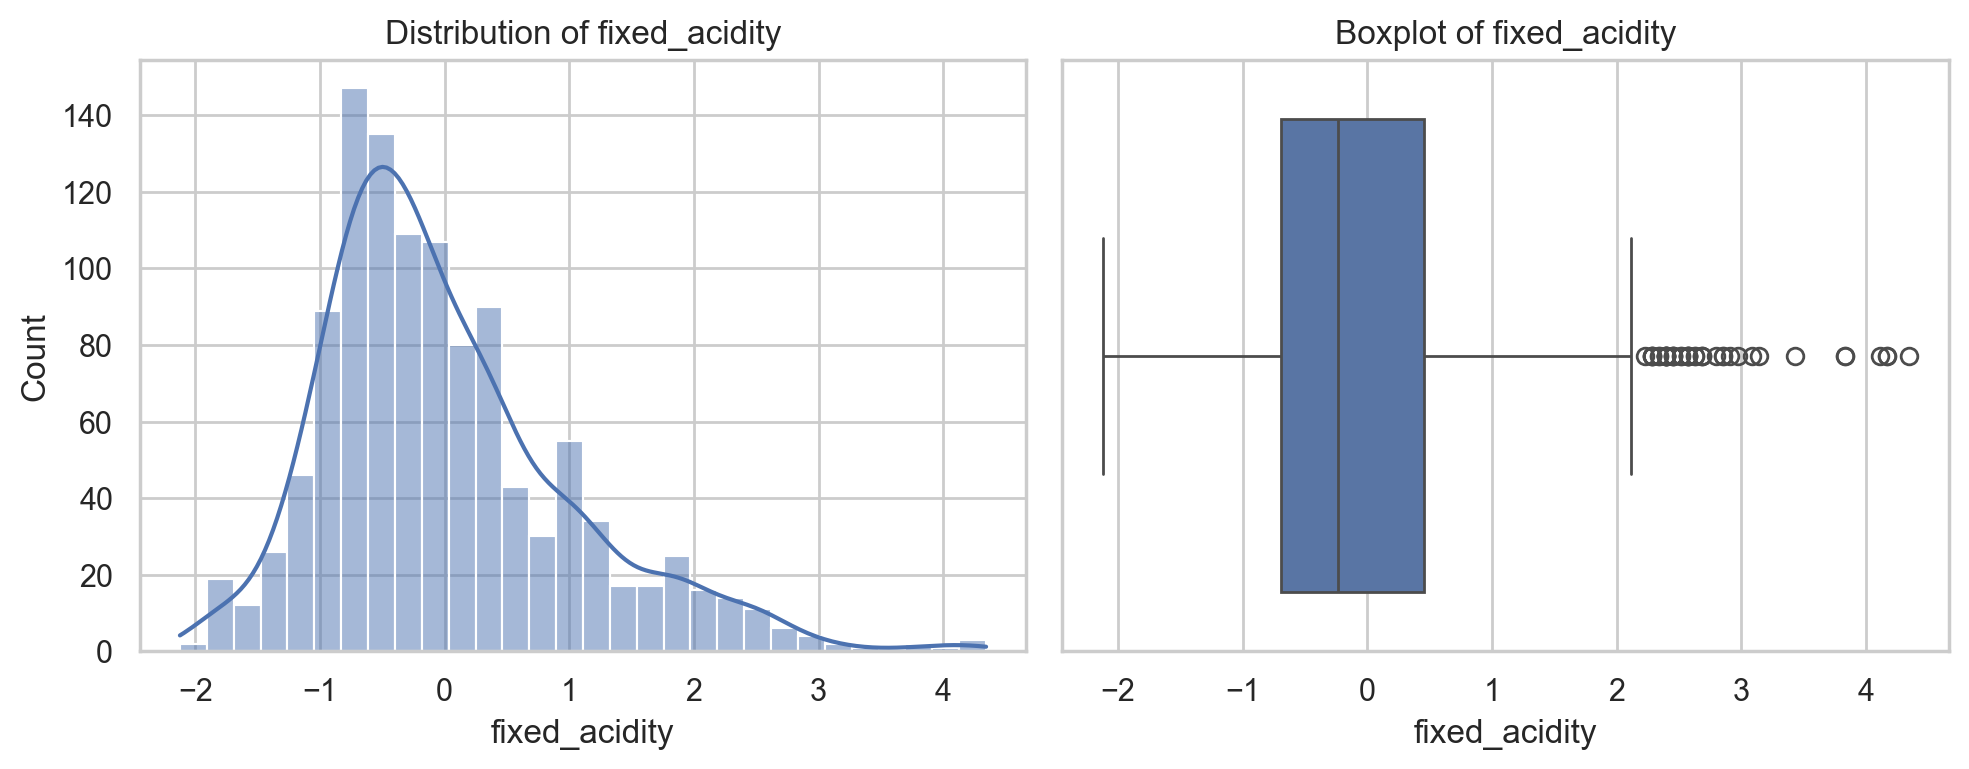

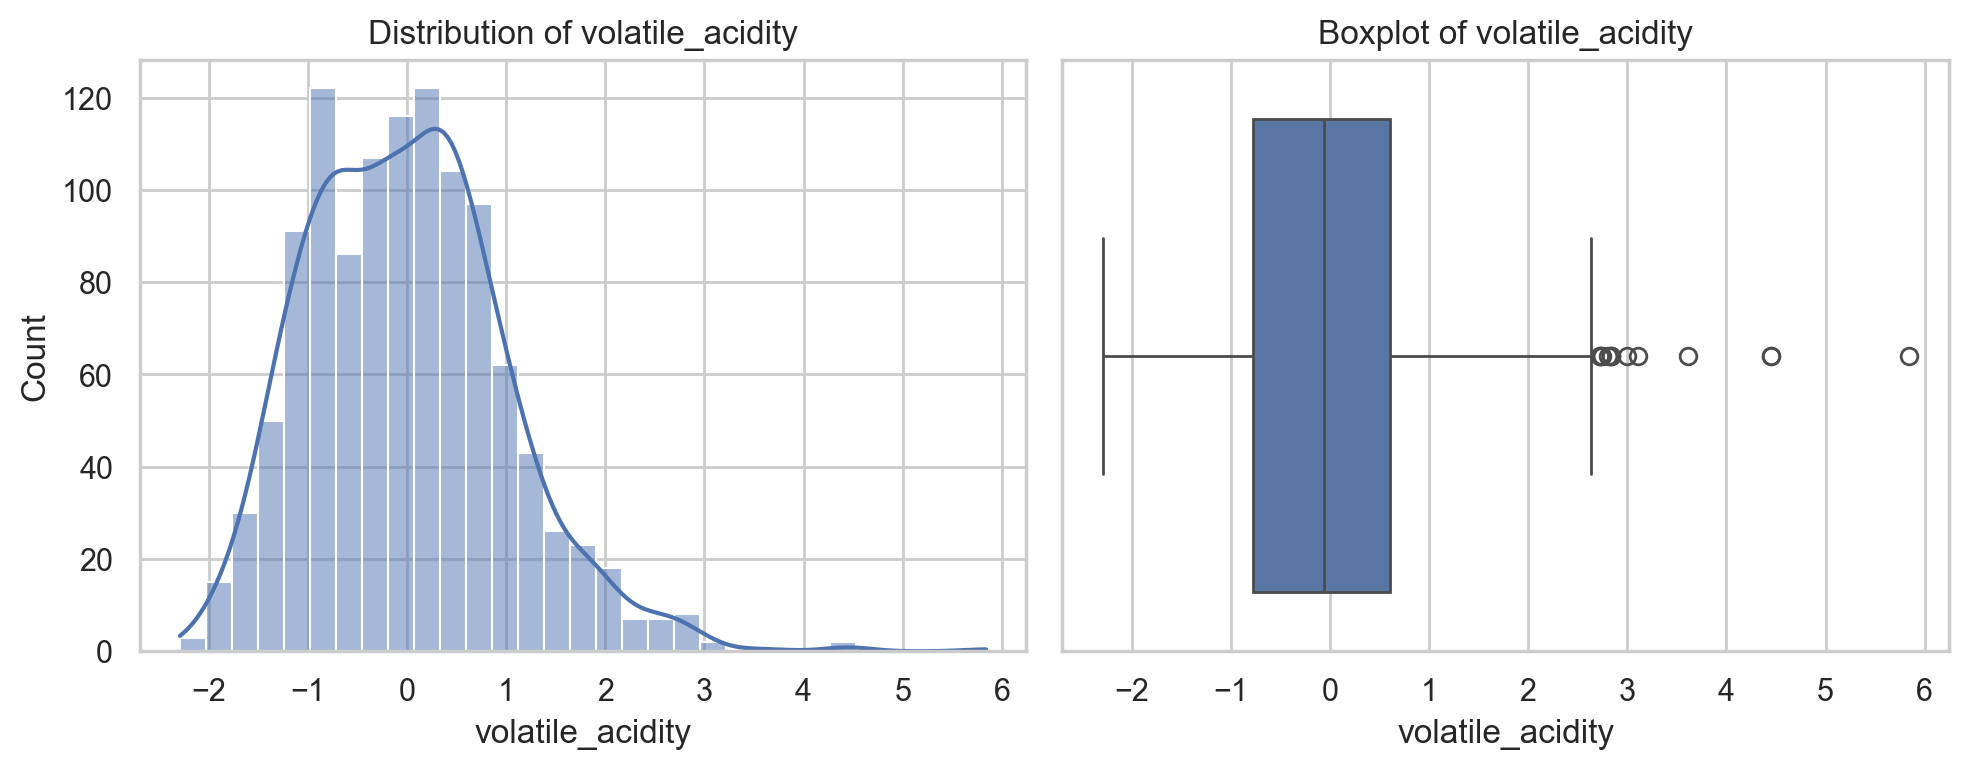

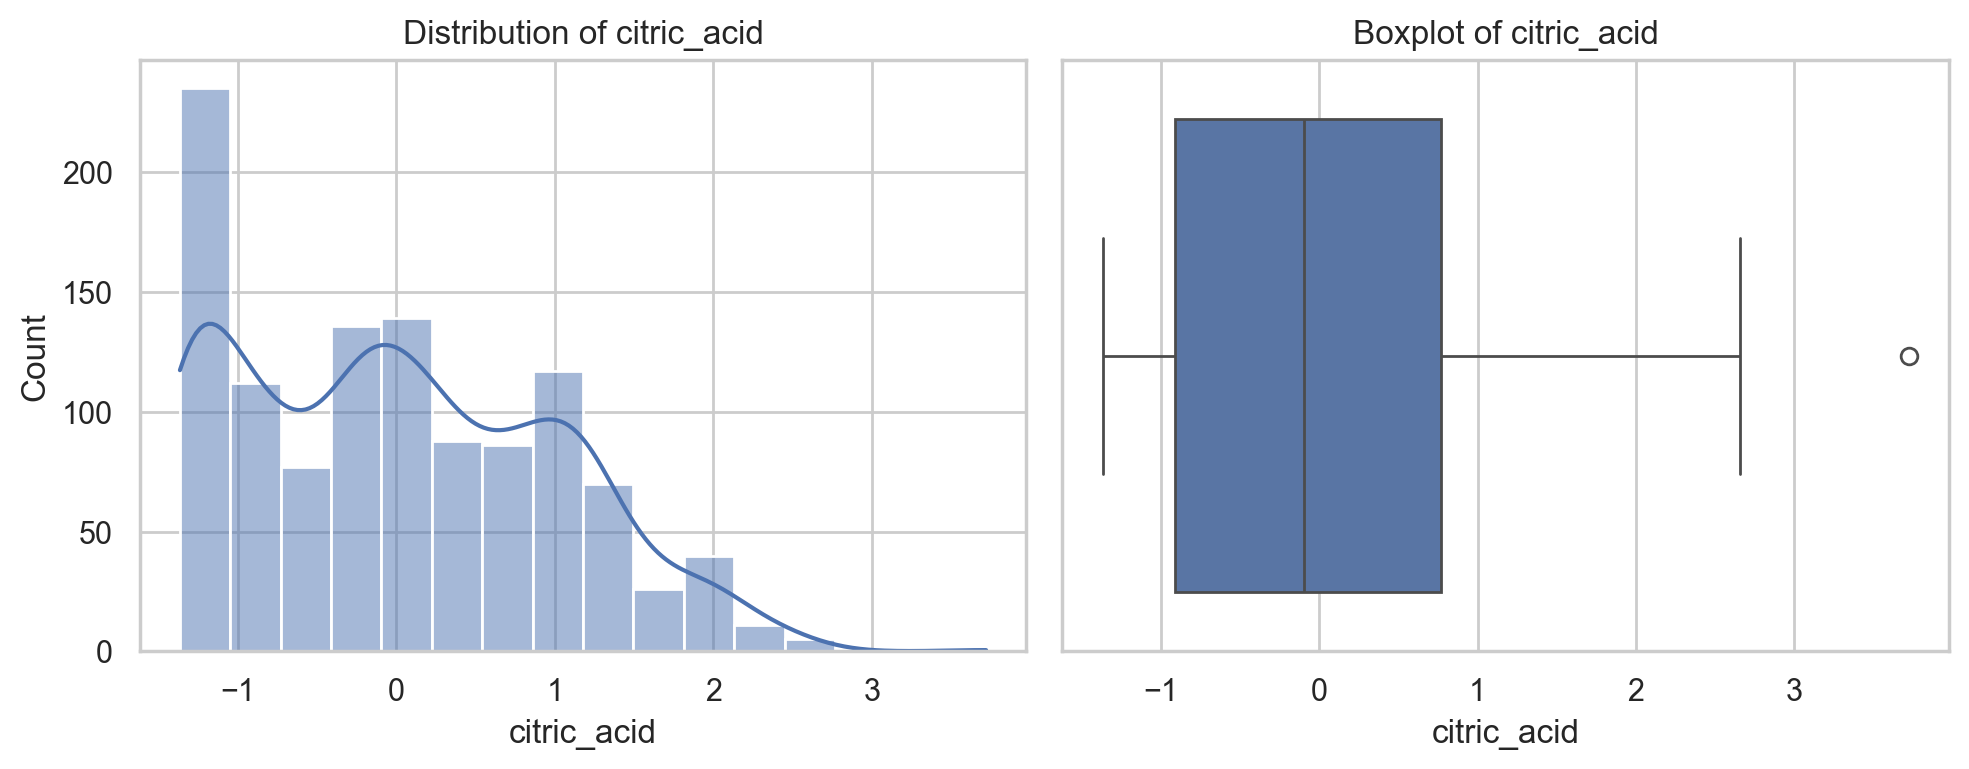

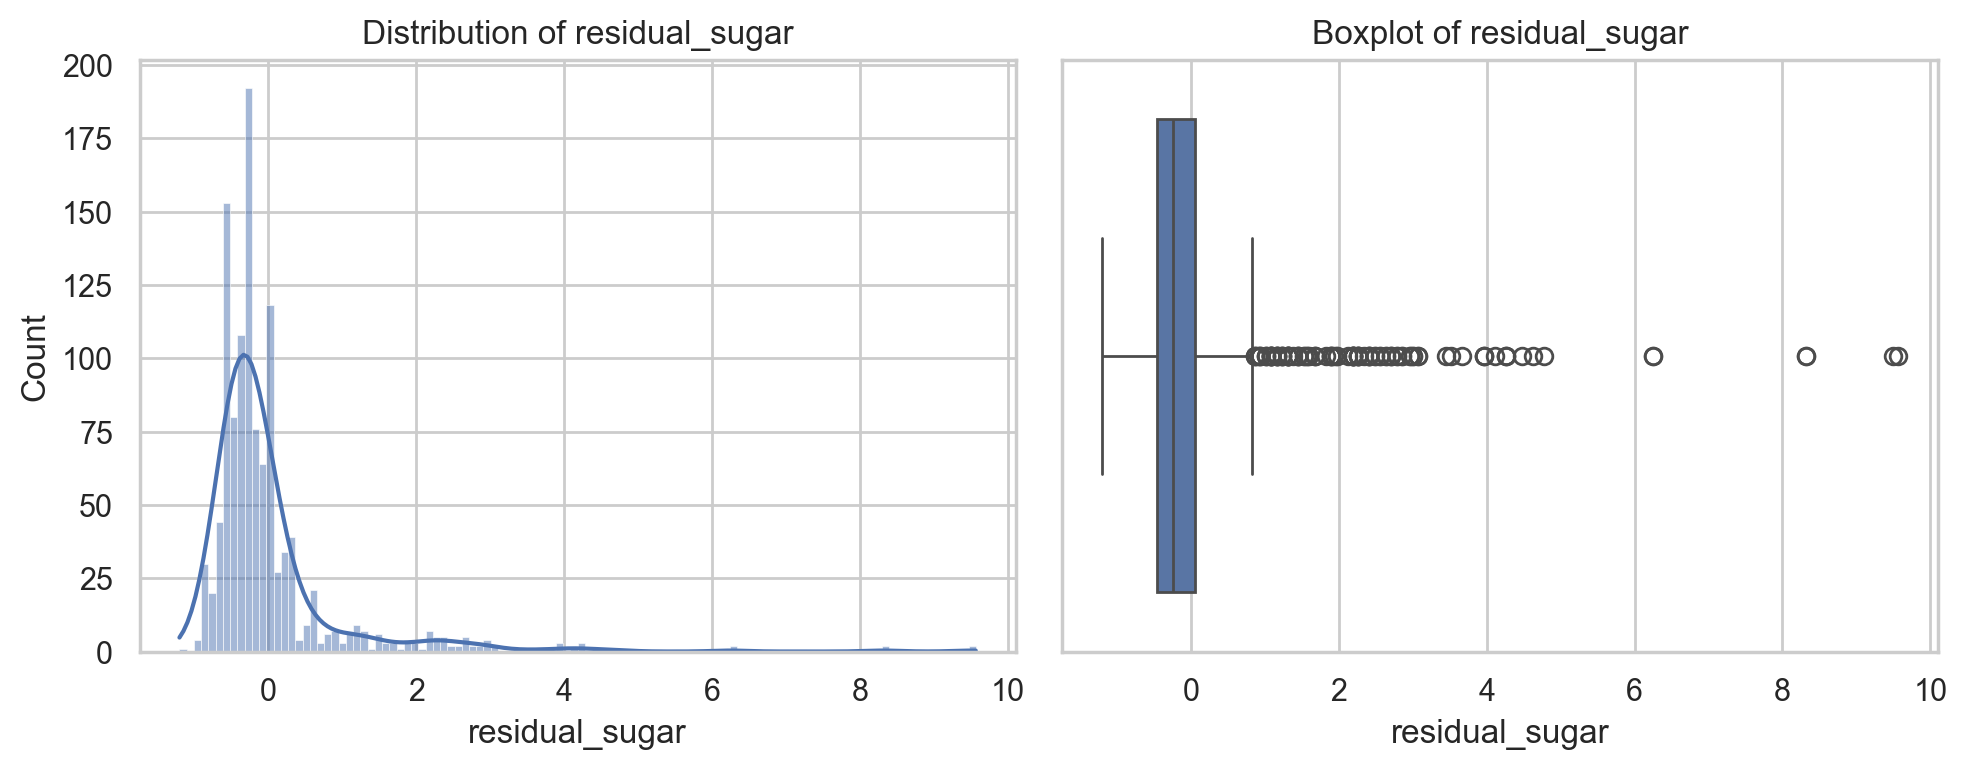

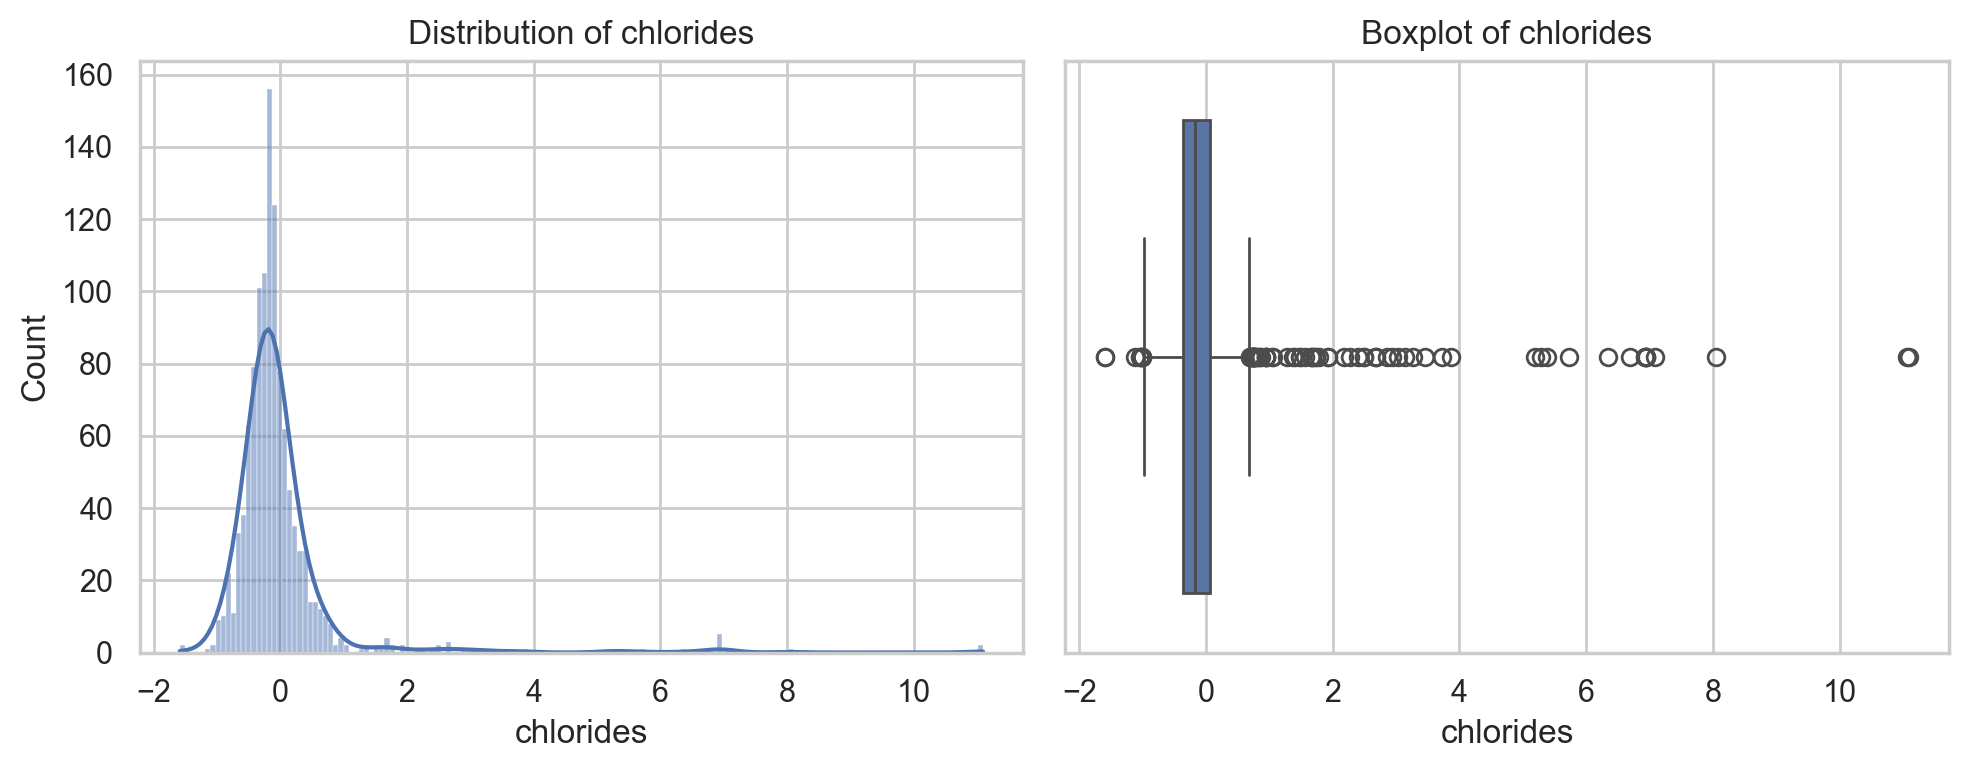

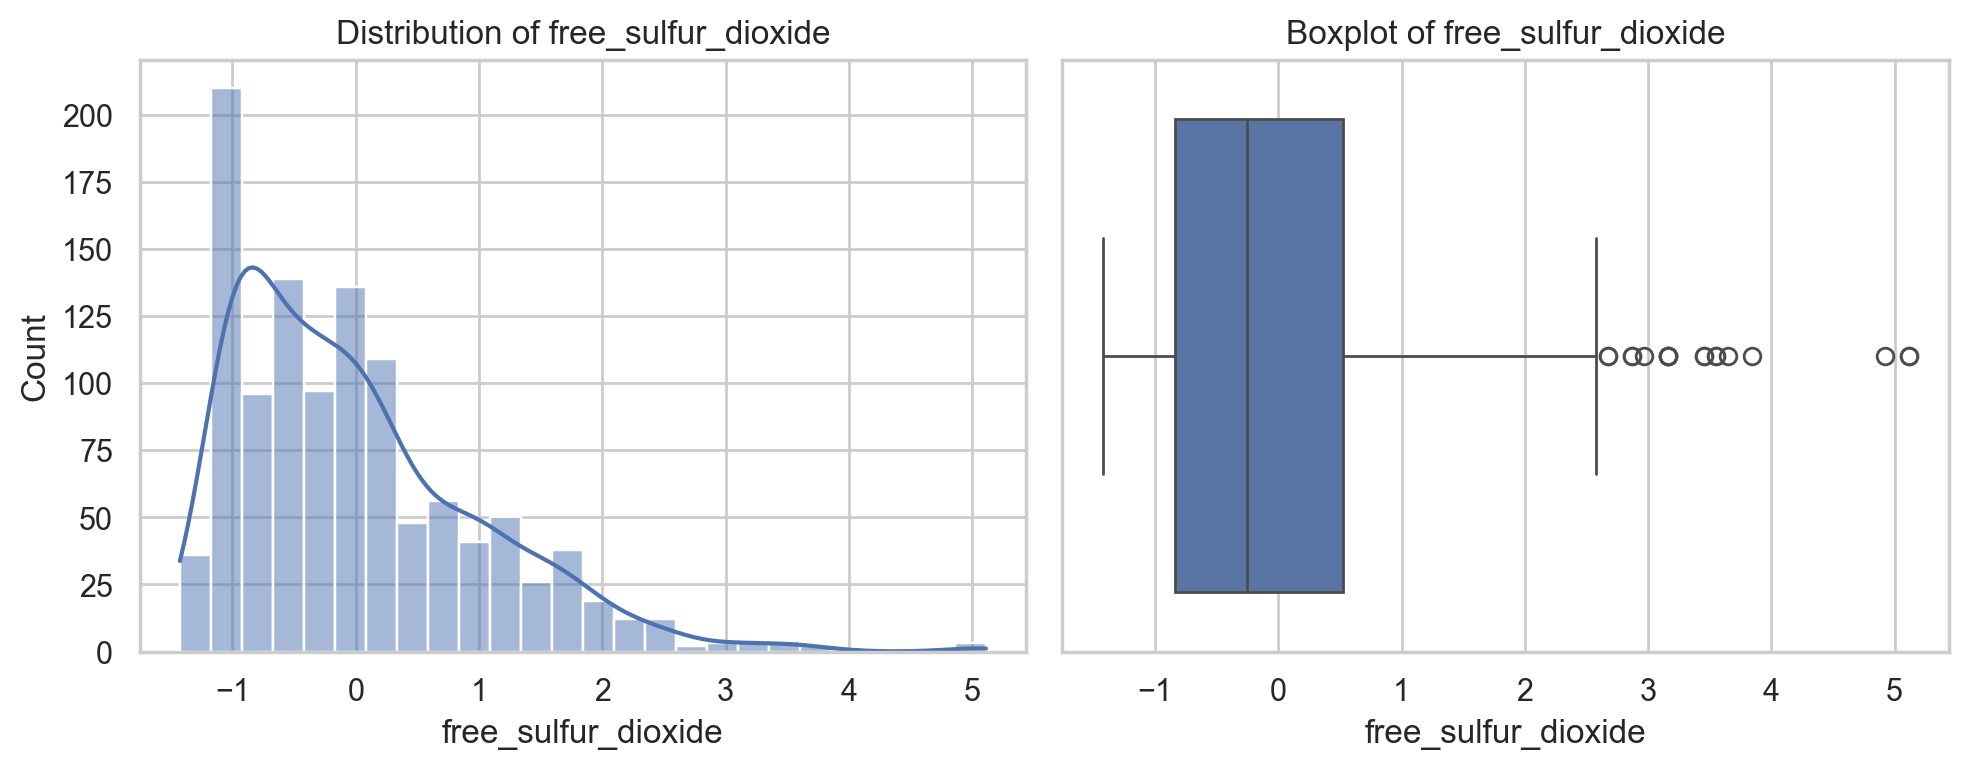

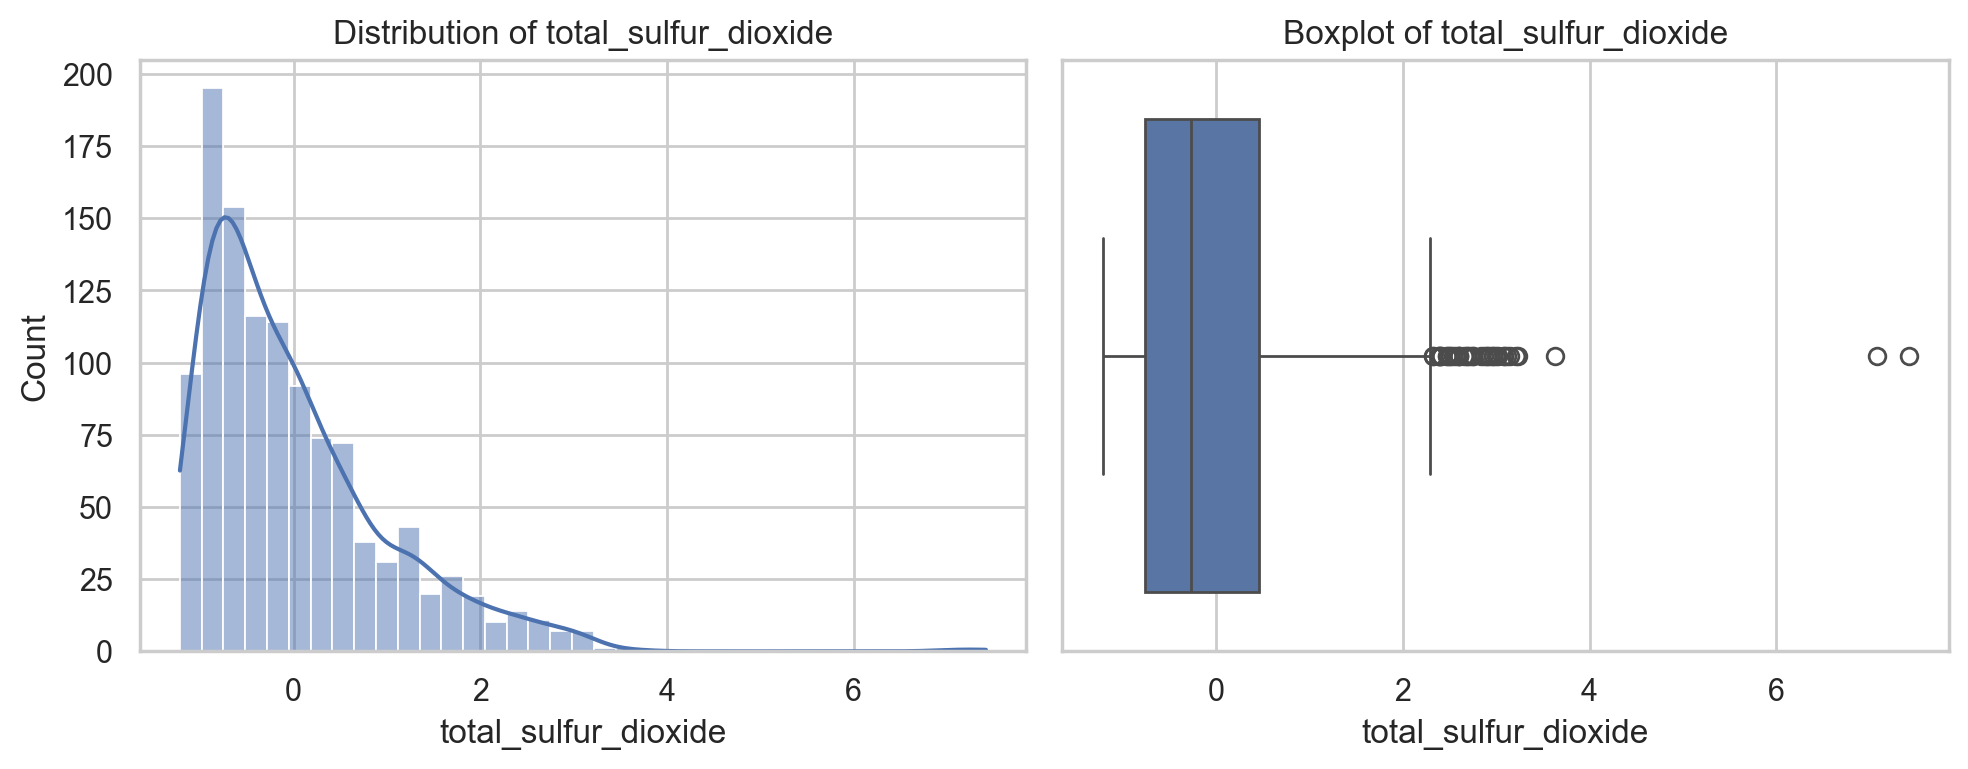

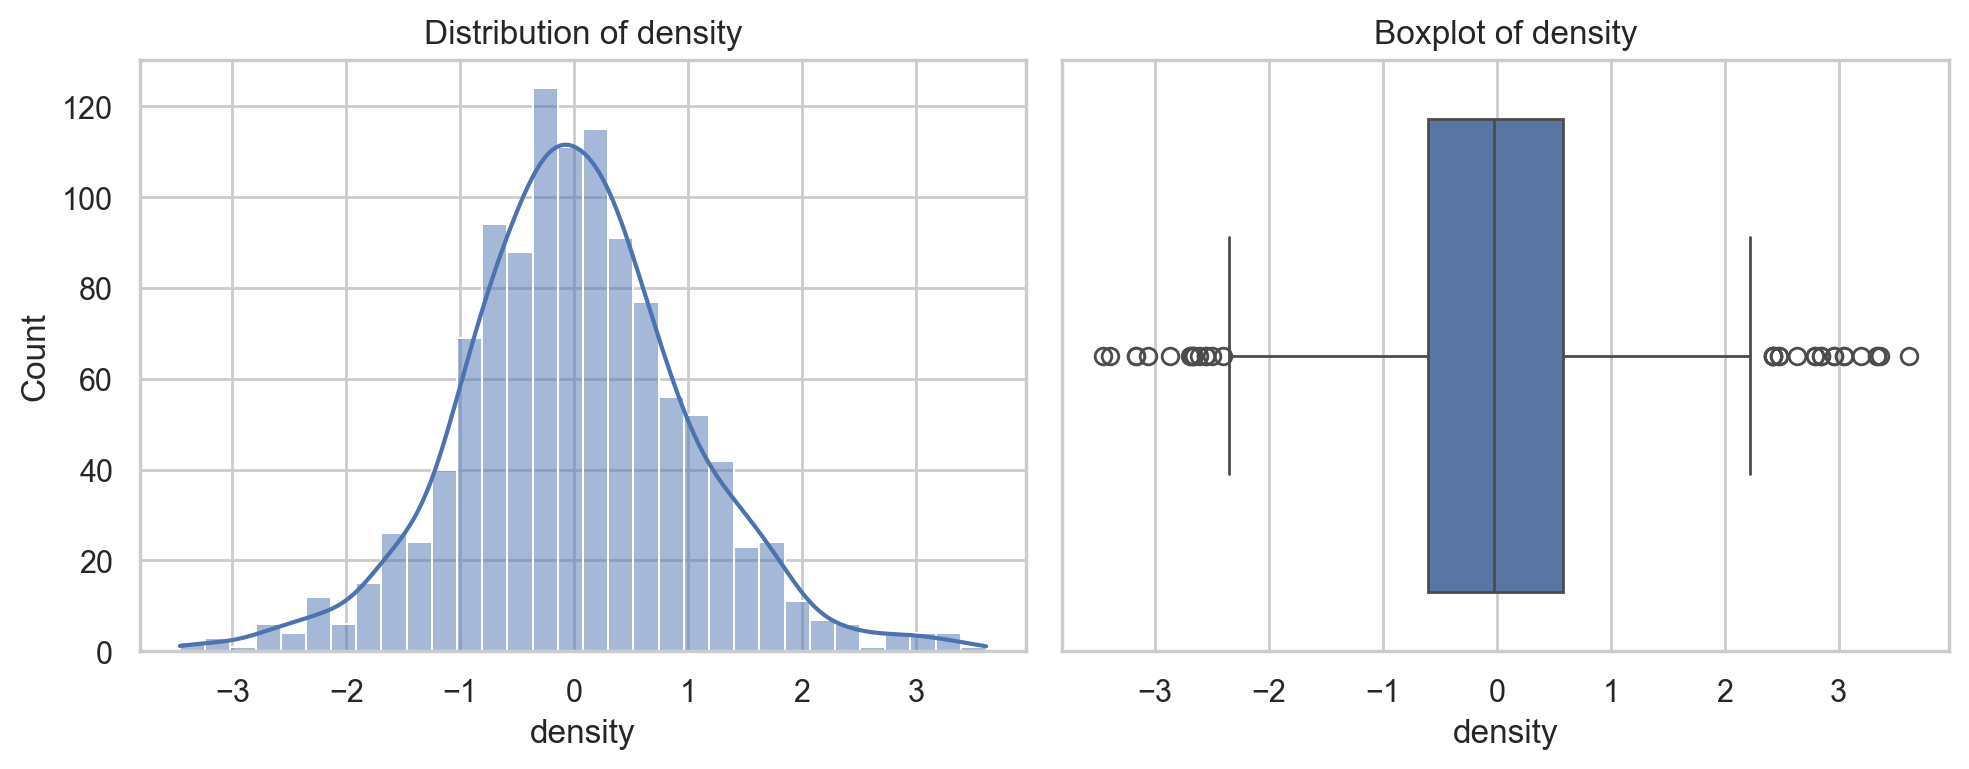

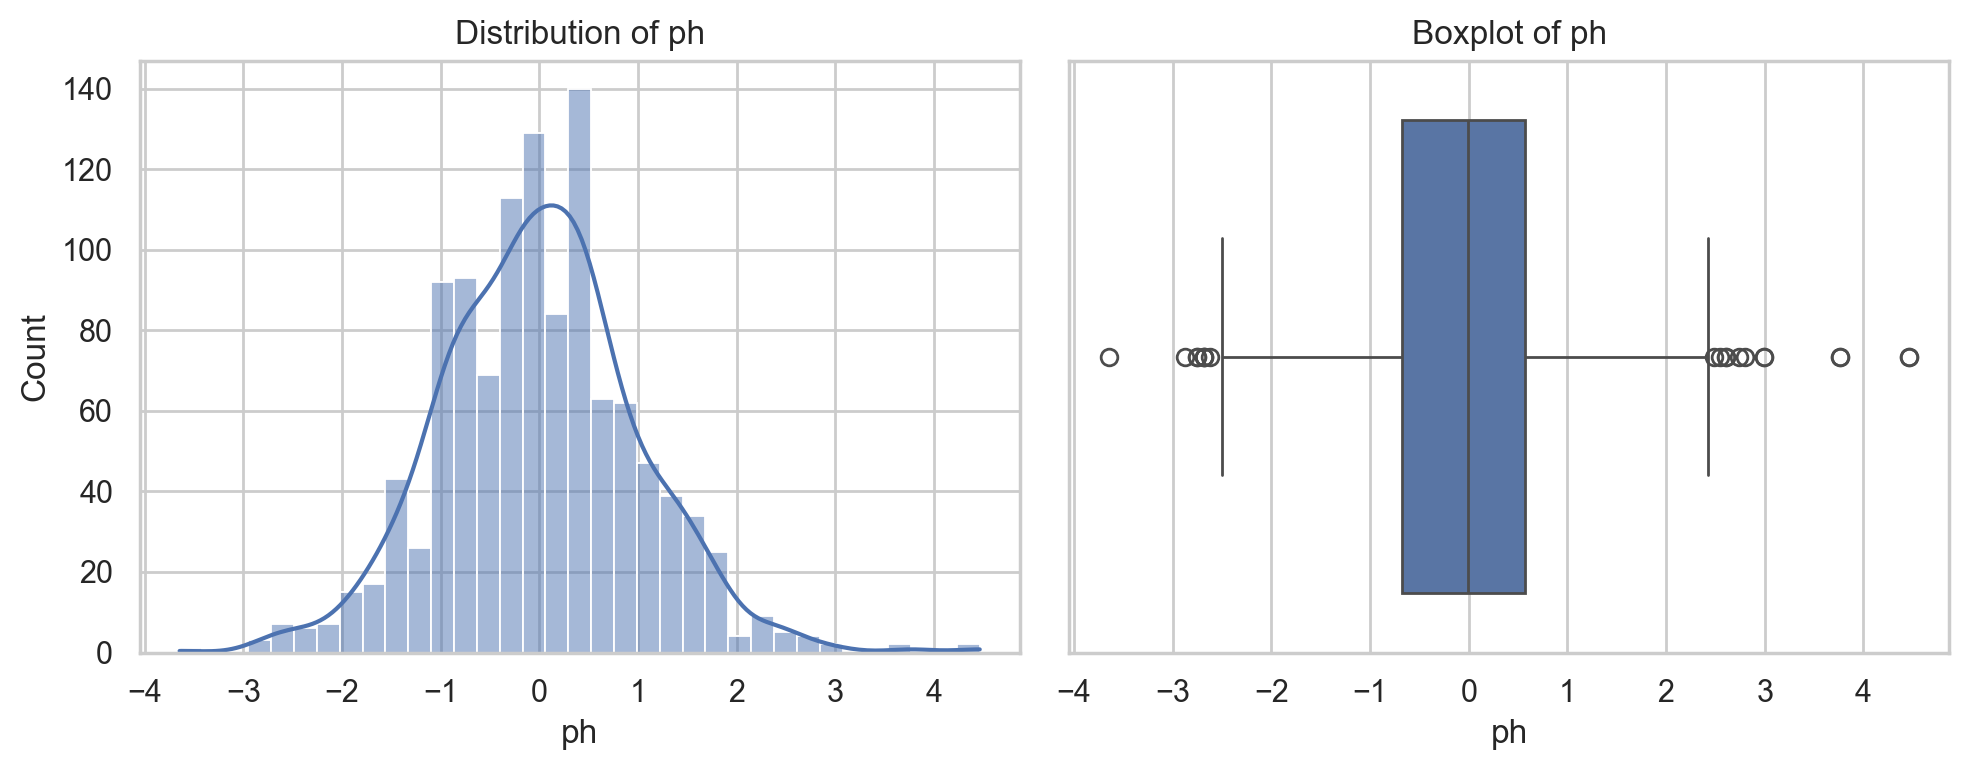

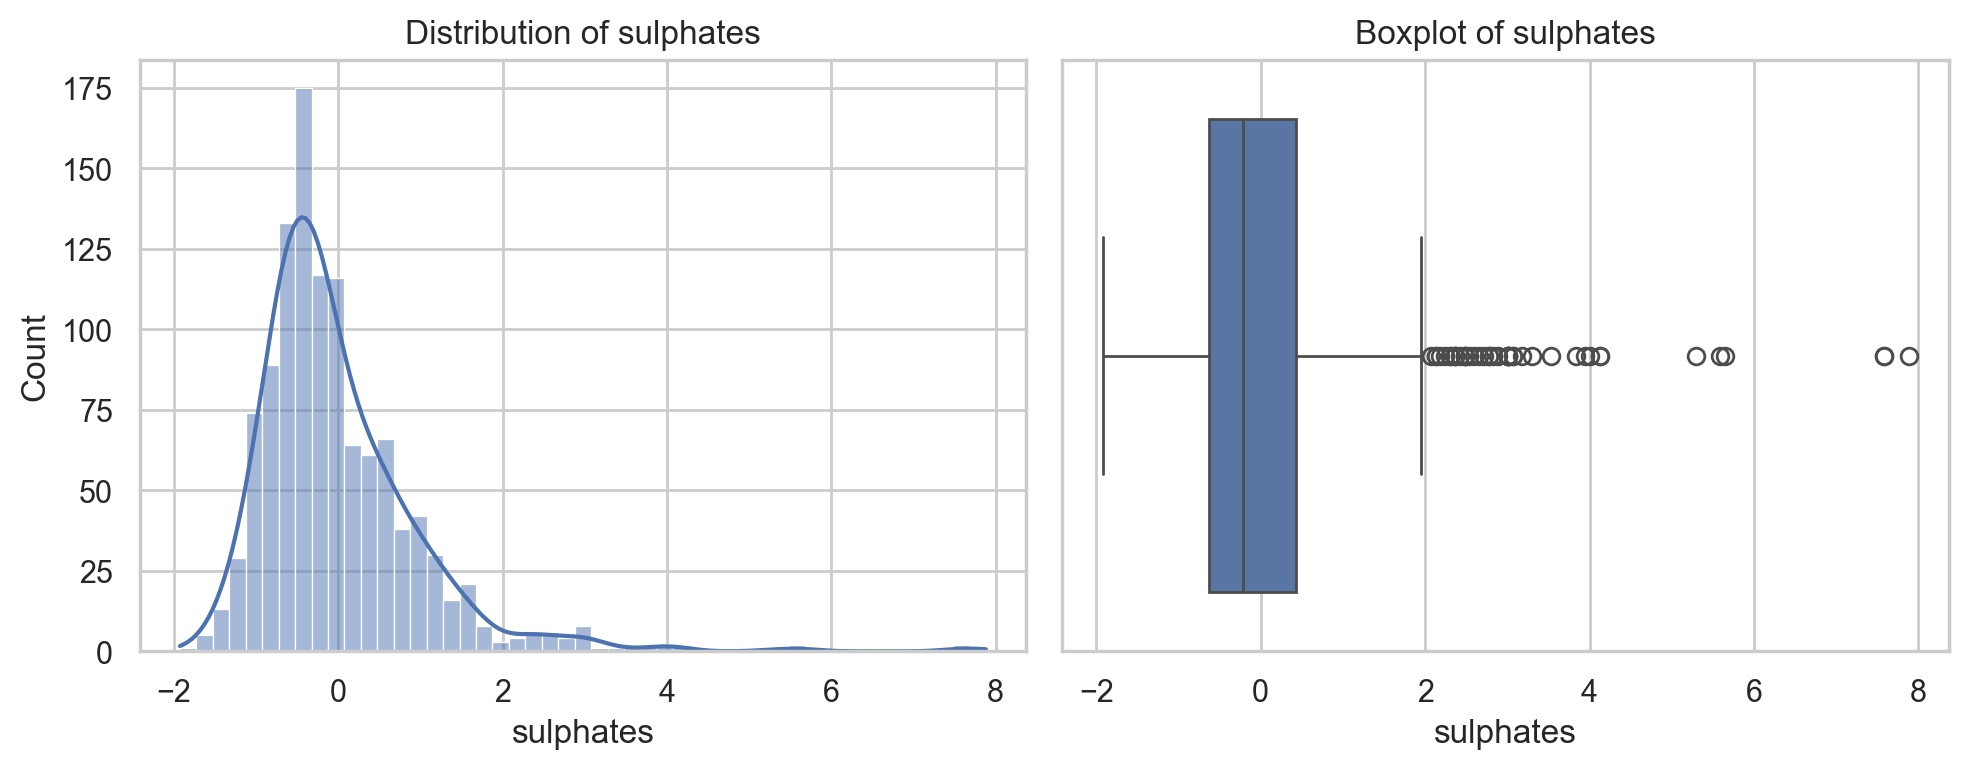

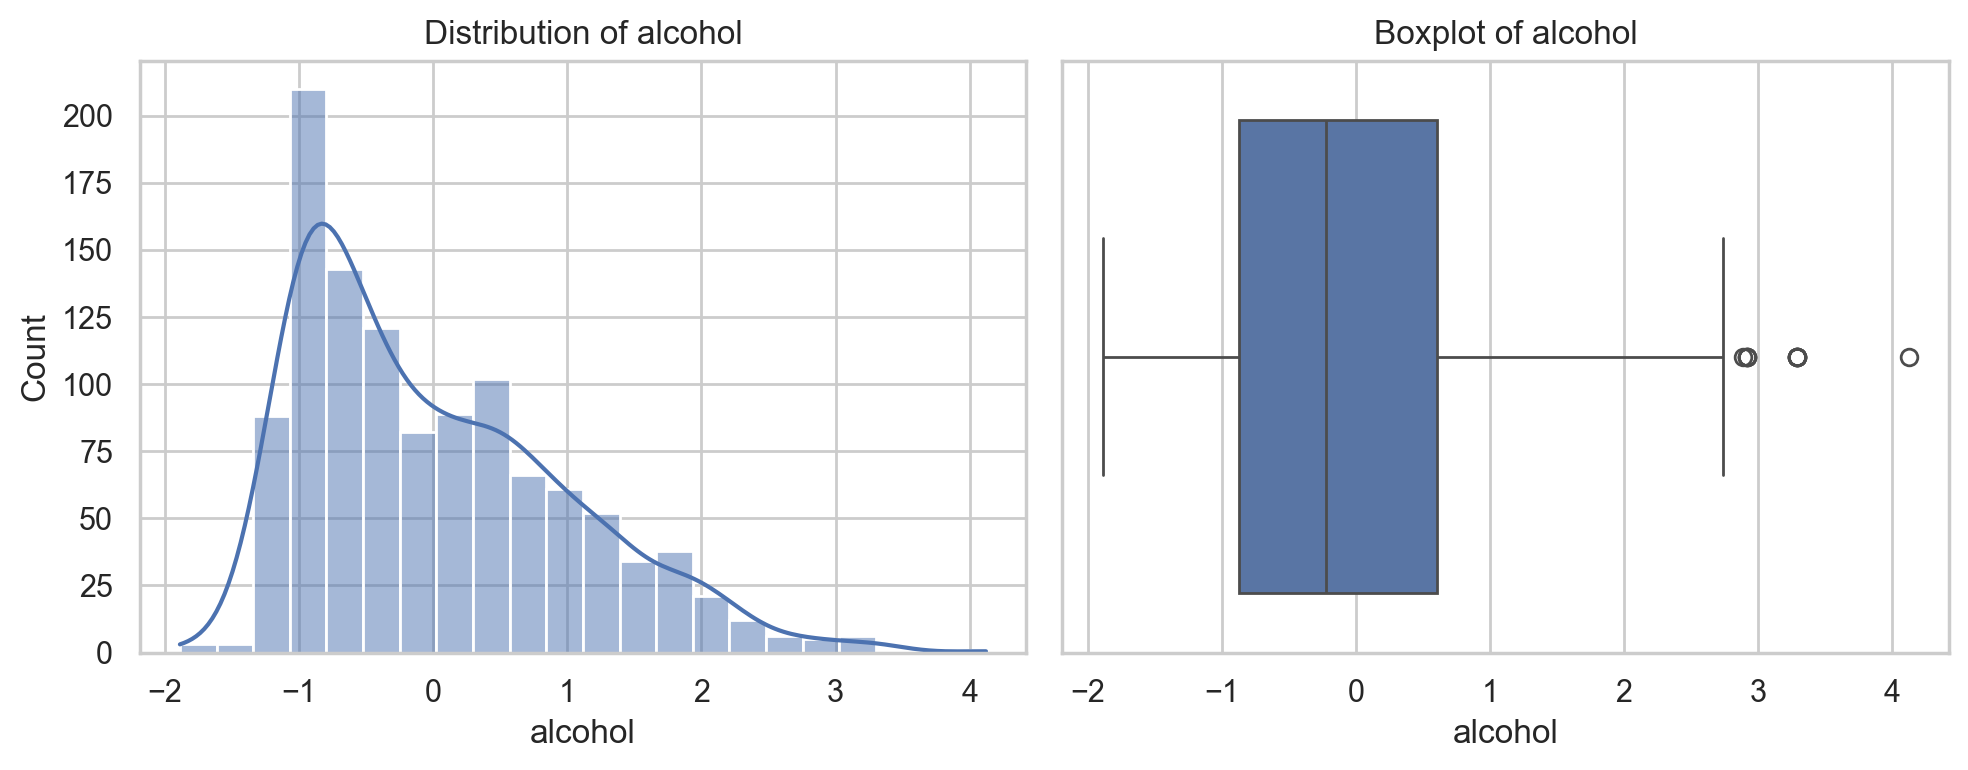

In [24]:
# %% 4.1 Univariate Analysis: Summary and Plots
def summarize_continuous(df: pd.DataFrame, features: List[str]) -> pd.DataFrame:
    """
    Compute summary statistics for continuous features.
    Returns a DataFrame with count, mean, std, min, quartiles, and max.
    """
    return df[features].describe().T


def plot_univariate_distribution(df: pd.DataFrame, feature: str) -> None:
    """
    Plot histogram and boxplot for a given feature.
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    sns.histplot(df[feature], kde=True, ax=axes[0])
    axes[0].set_title(f'Distribution of {feature}')
    sns.boxplot(x=df[feature], ax=axes[1])
    axes[1].set_title(f'Boxplot of {feature}')
    plt.tight_layout()


# List of continuous feature names
continuous_features: List[str] = [
    "fixed_acidity", "volatile_acidity", "citric_acid",
    "residual_sugar", "chlorides", "free_sulfur_dioxide",
    "total_sulfur_dioxide", "density", "ph", "sulphates", "alcohol"
]

# 1. Display summary statistics
summary_df: pd.DataFrame = summarize_continuous(df, continuous_features)
print("Summary Statistics for Continuous Features:")
display(summary_df)

# 2. Plot distributions for each feature and close figures
for feat in continuous_features:
    plot_univariate_distribution(df, feat)

### 4.2 Bivariate Analysis

Next, we quantify linear associations via the **Pearson correlation coefficient**:
$$
  \rho_{X,Y} = \frac{\operatorname{cov}(X,Y)}{\sigma_X \sigma_Y}
  = \frac{\frac{1}{n-1}\sum_{i=1}^n (X_i - \bar{X})(Y_i - \bar{Y})}
         {\sqrt{\frac{1}{n-1}\sum (X_i - \bar{X})^2}\,\sqrt{\frac{1}{n-1}\sum (Y_i - \bar{Y})^2}}.
$$
We then visualize the correlation matrix as a heatmap and inspect key scatterplots for `quality` against top correlated features.

Correlation matrix computed.


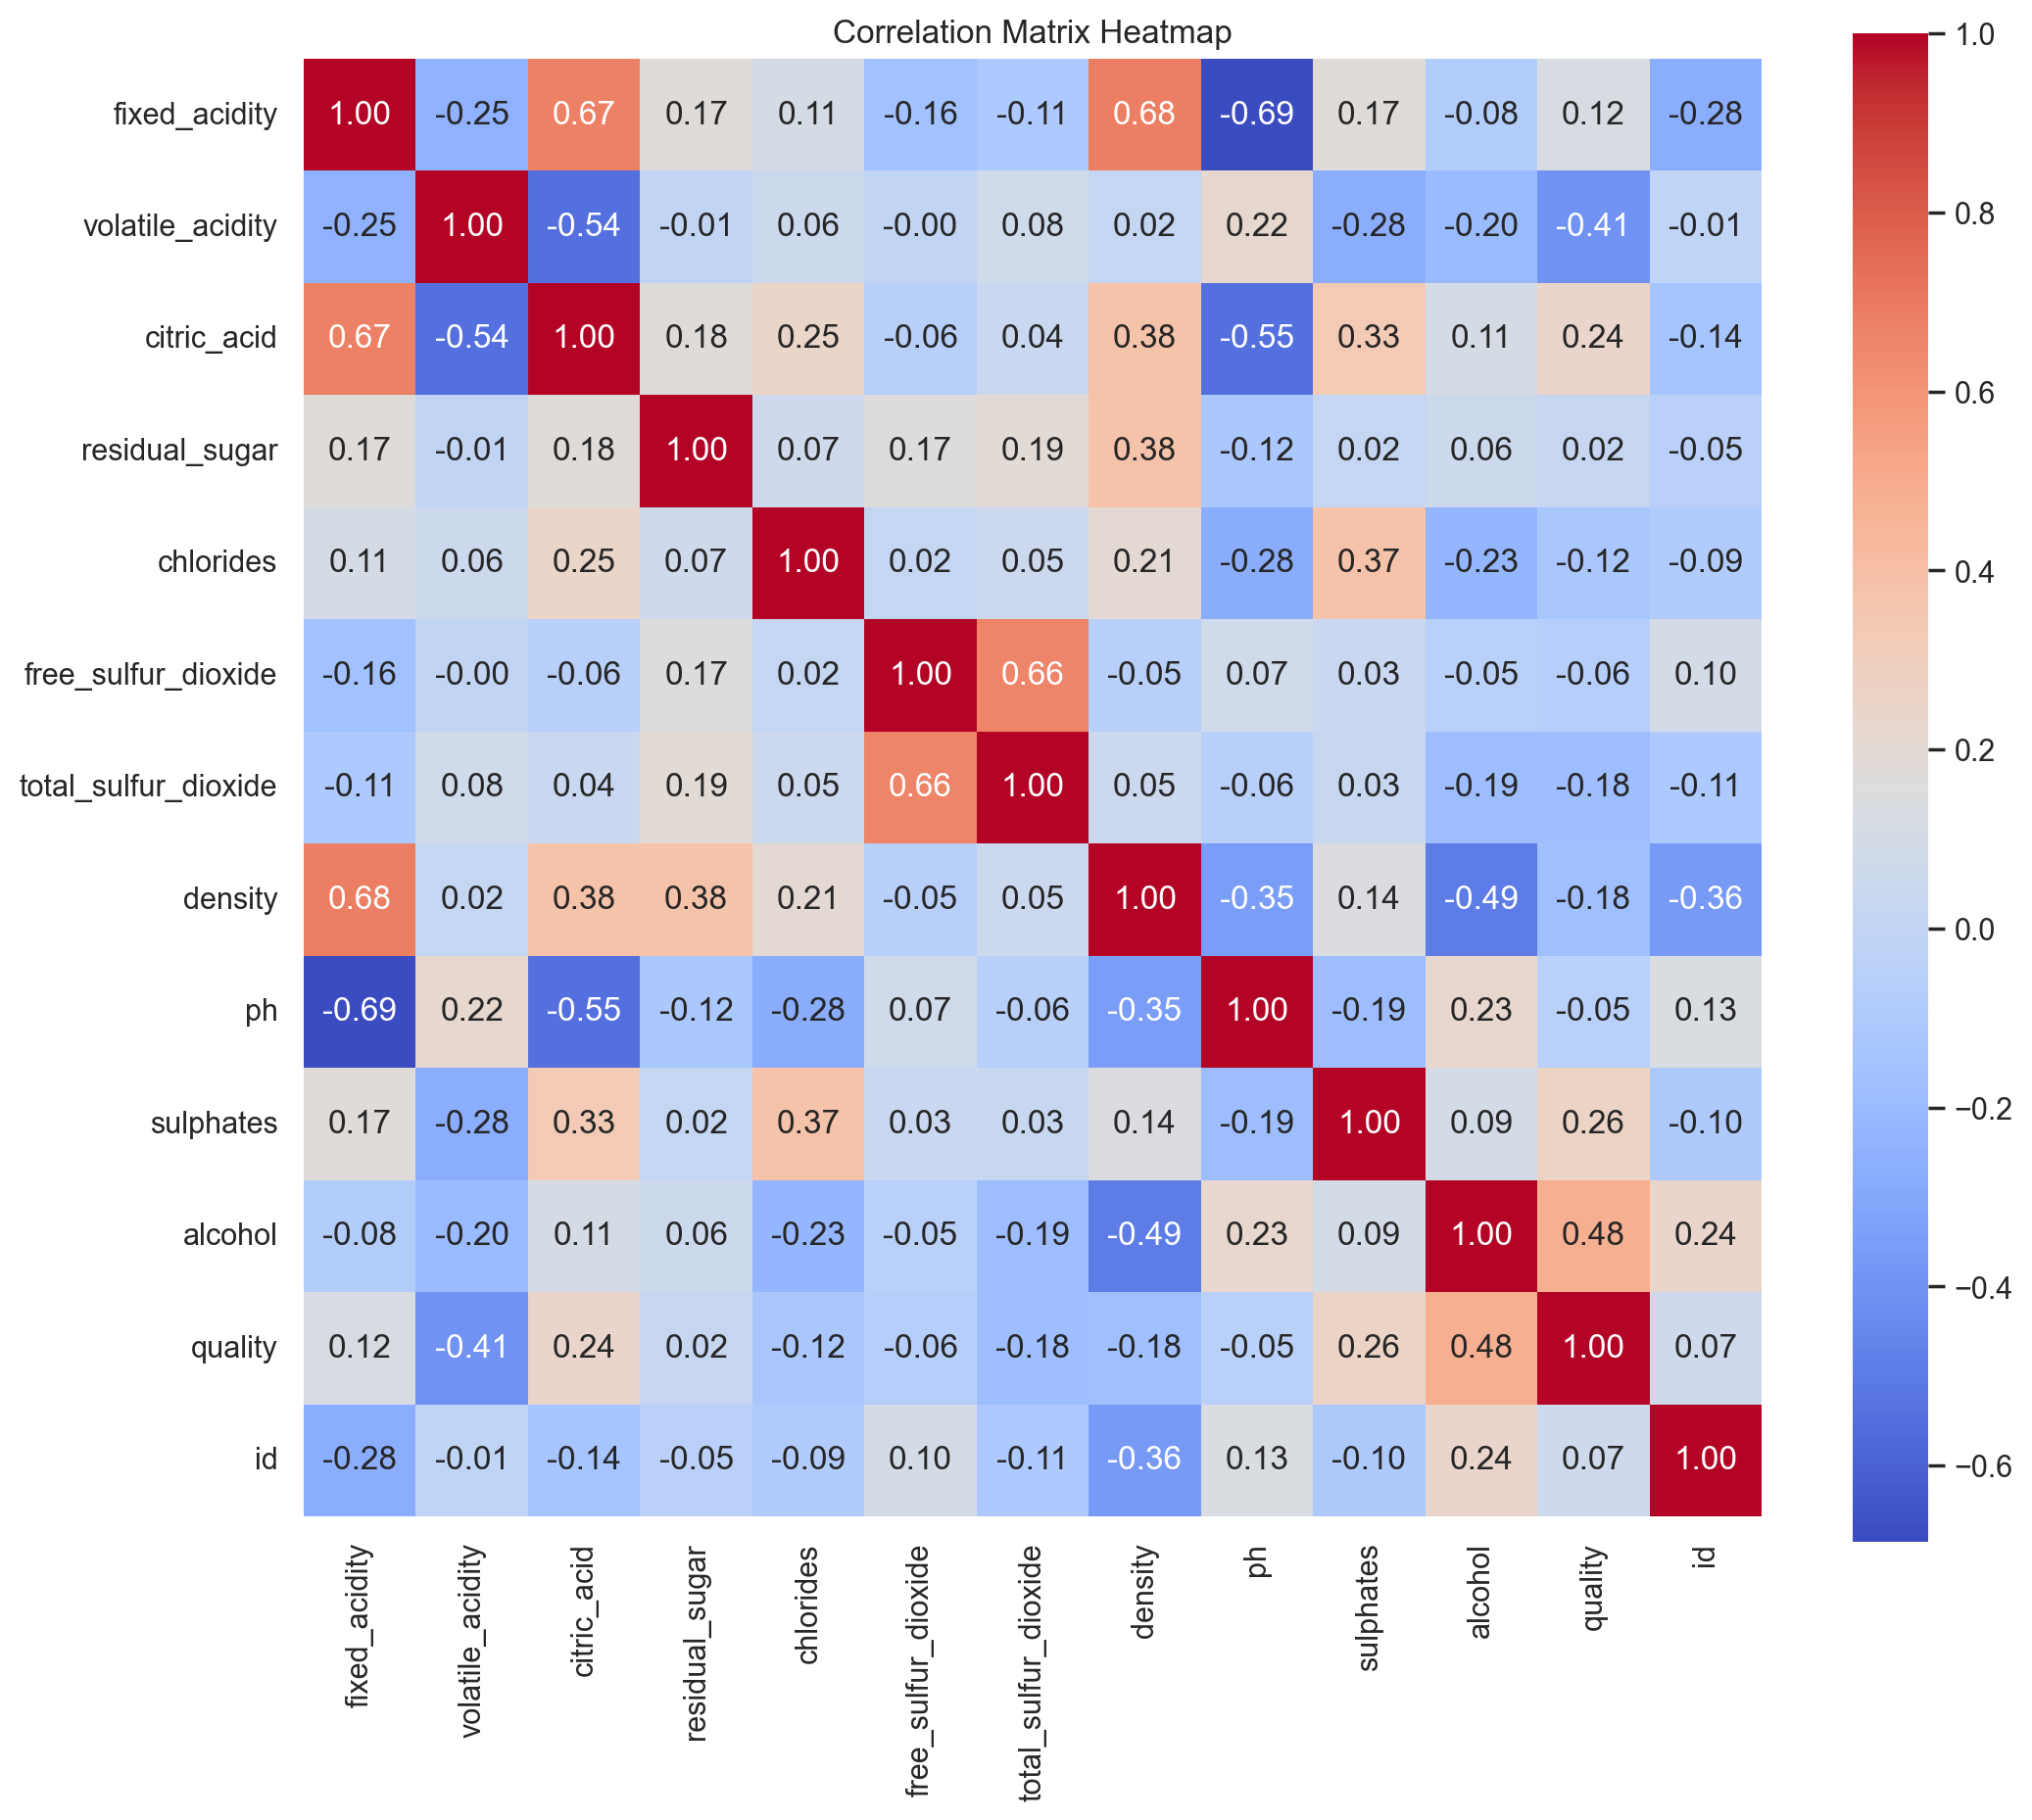

Top features correlated with quality: ['alcohol', 'volatile_acidity', 'sulphates']


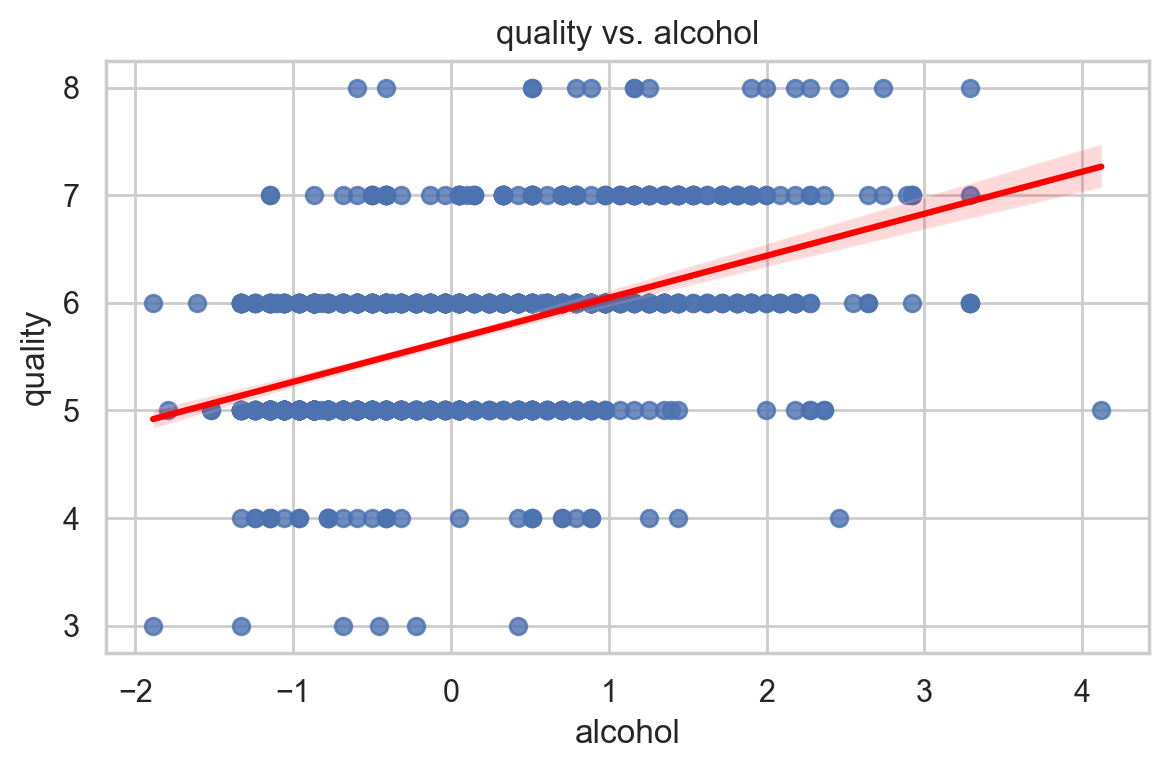

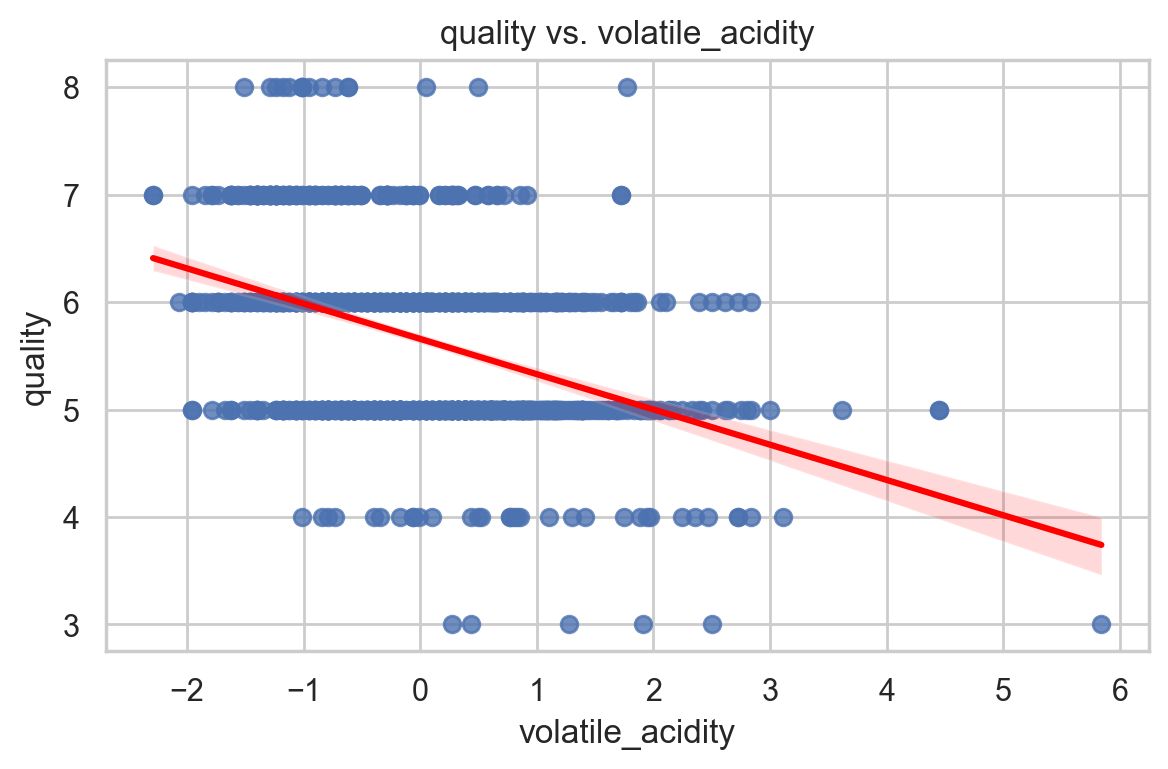

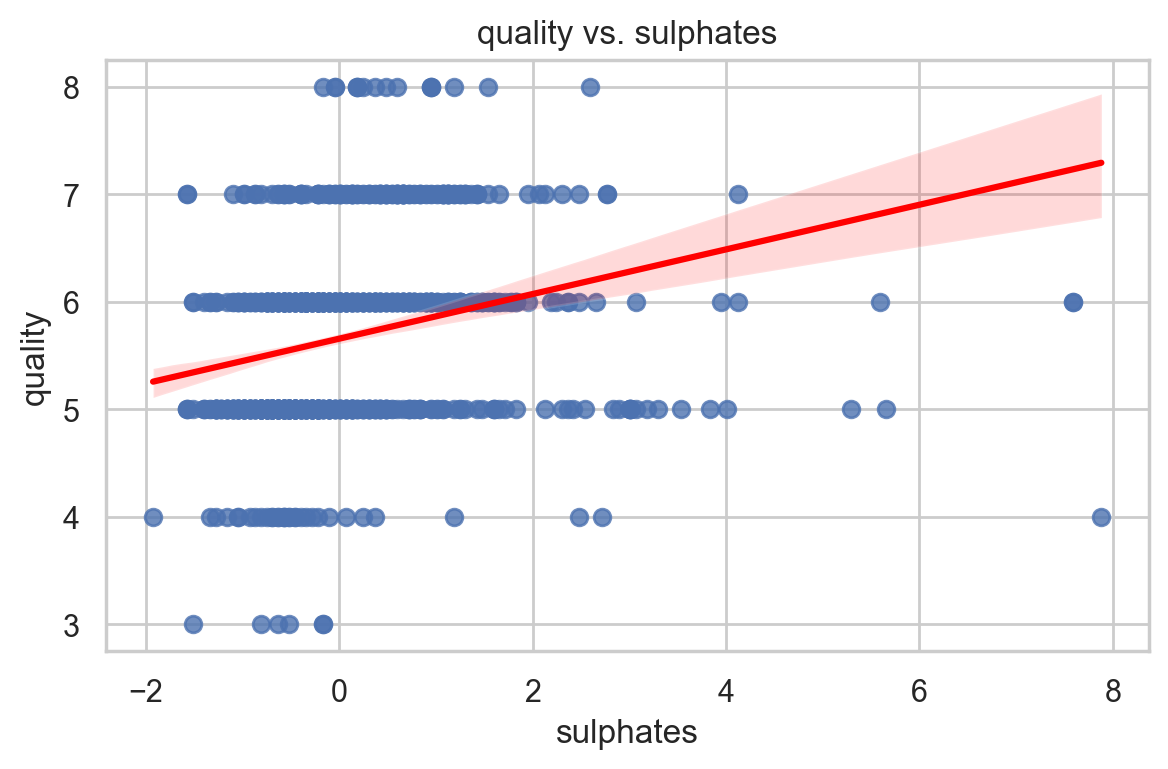

In [25]:
# %% 4.2 Bivariate Analysis: Correlation and Scatterplots

def compute_correlation_matrix(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute the Pearson correlation matrix for all numeric columns.
    """
    return df.corr()


def plot_correlation_heatmap(corr_matrix: pd.DataFrame) -> None:
    """
    Visualize the correlation matrix as a heatmap.
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f",
                cmap="coolwarm", square=True)
    plt.title("Correlation Matrix Heatmap")
    plt.show()


def plot_scatter(df: pd.DataFrame, x: str, y: str) -> None:
    """
    Plot a scatterplot for two variables with a regression line.
    """
    plt.figure(figsize=(6, 4))
    sns.regplot(x=df[x], y=df[y], line_kws={"color": "red"})
    plt.title(f"{y} vs. {x}")
    plt.xlabel(x)
    plt.ylabel(y)
    plt.tight_layout()


# 1. Correlation matrix
corr_mat: pd.DataFrame = compute_correlation_matrix(df)
print("Correlation matrix computed.")
plot_correlation_heatmap(corr_mat)

# 2. Scatterplots of quality vs. top correlated features
# Identify top 3 features most correlated (in absolute value) with 'quality'
corr_with_quality: pd.Series = corr_mat["quality"].abs(
).sort_values(ascending=False)
top_features: List[str] = corr_with_quality.index.drop("quality")[:3].tolist()
print(f"Top features correlated with quality: {top_features}")

for feature in top_features:
    plot_scatter(df, feature, "quality")

### 4.3 Empirical Cumulative Distribution Functions (ECDF)

We inspect the empirical distribution of key variables (e.g. `quality`) via the ECDF:

$$
F_X(x) \;=\; \frac{1}{n}\sum_{i=1}^n \mathbf{1}_{\{X_i \le x\}}
$$

This helps reveal skewness, heavy tails, and percentiles more precisely than histograms.


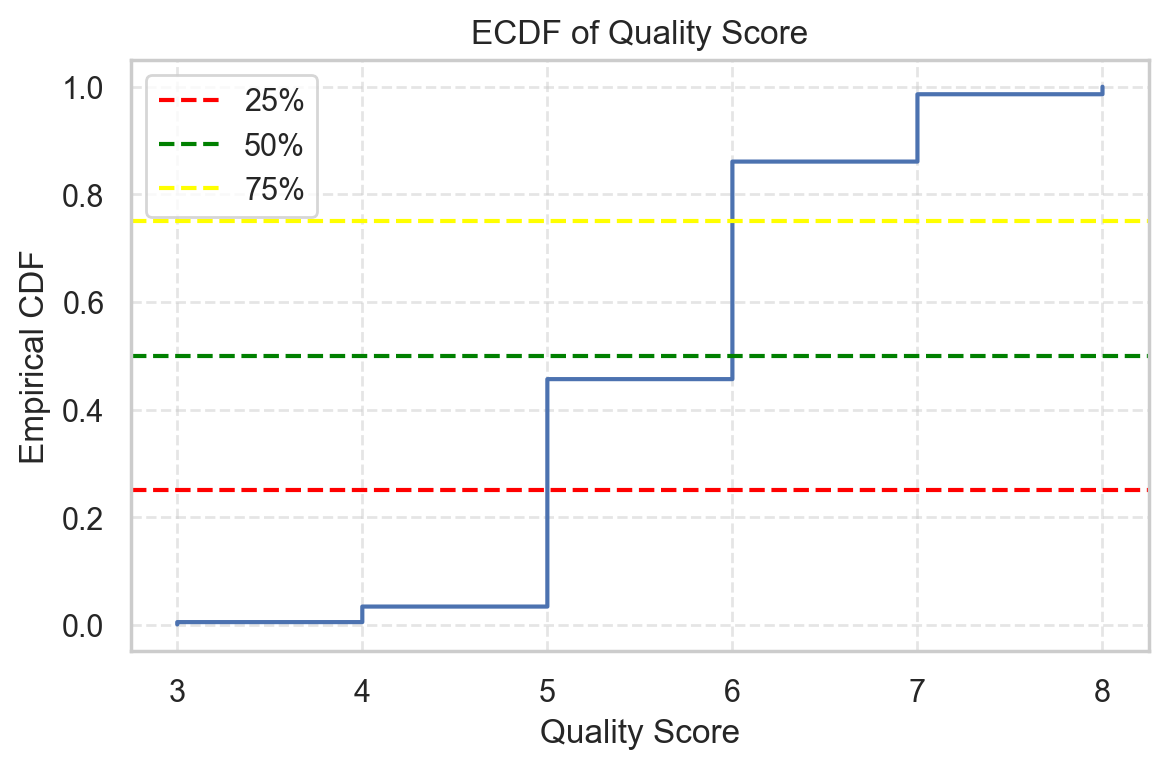

In [26]:
# %% 4.3 ECDF plot function

def plot_ecdf(series: pd.Series, label: str) -> None:
    """
    Plot the empirical cumulative distribution function for a pandas Series.
    """
    data: np.ndarray = np.sort(series.values)
    cum_prob: np.ndarray = np.arange(1, len(data) + 1) / len(data)
    plt.figure(figsize=(6, 4))
    plt.step(data, cum_prob, where="post")
    plt.axhline(1 / 4, linestyle="--", color="red", label="25%")
    plt.axhline(1 / 2, linestyle="--", color="green", label="50%")
    plt.axhline(3 / 4, linestyle="--", color="yellow", label="75%")
    plt.title(f"ECDF of {label}")
    plt.xlabel(label)
    plt.ylabel("Empirical CDF")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.legend()
    plt.show()


# Example: ECDF of quality scores
plot_ecdf(df["quality"], "Quality Score")

### 4.4 Principal Component Analysis (PCA)

We perform PCA on the standardized features to concentrate variance in fewer axes.  
Let $\lambda_k$ be the $k$-th eigenvalue of the covariance matrix, then

$$
\text{Variance ratio}_k = \frac{\lambda_k}{\sum_{j=1}^p \lambda_j},\quad
\text{CumulVar}_k = \sum_{j=1}^k \text{Variance ratio}_j.
$$

We choose the number of components via the “elbow” in the cumulative plot (here 5 PCs to capture ≥ 80%).


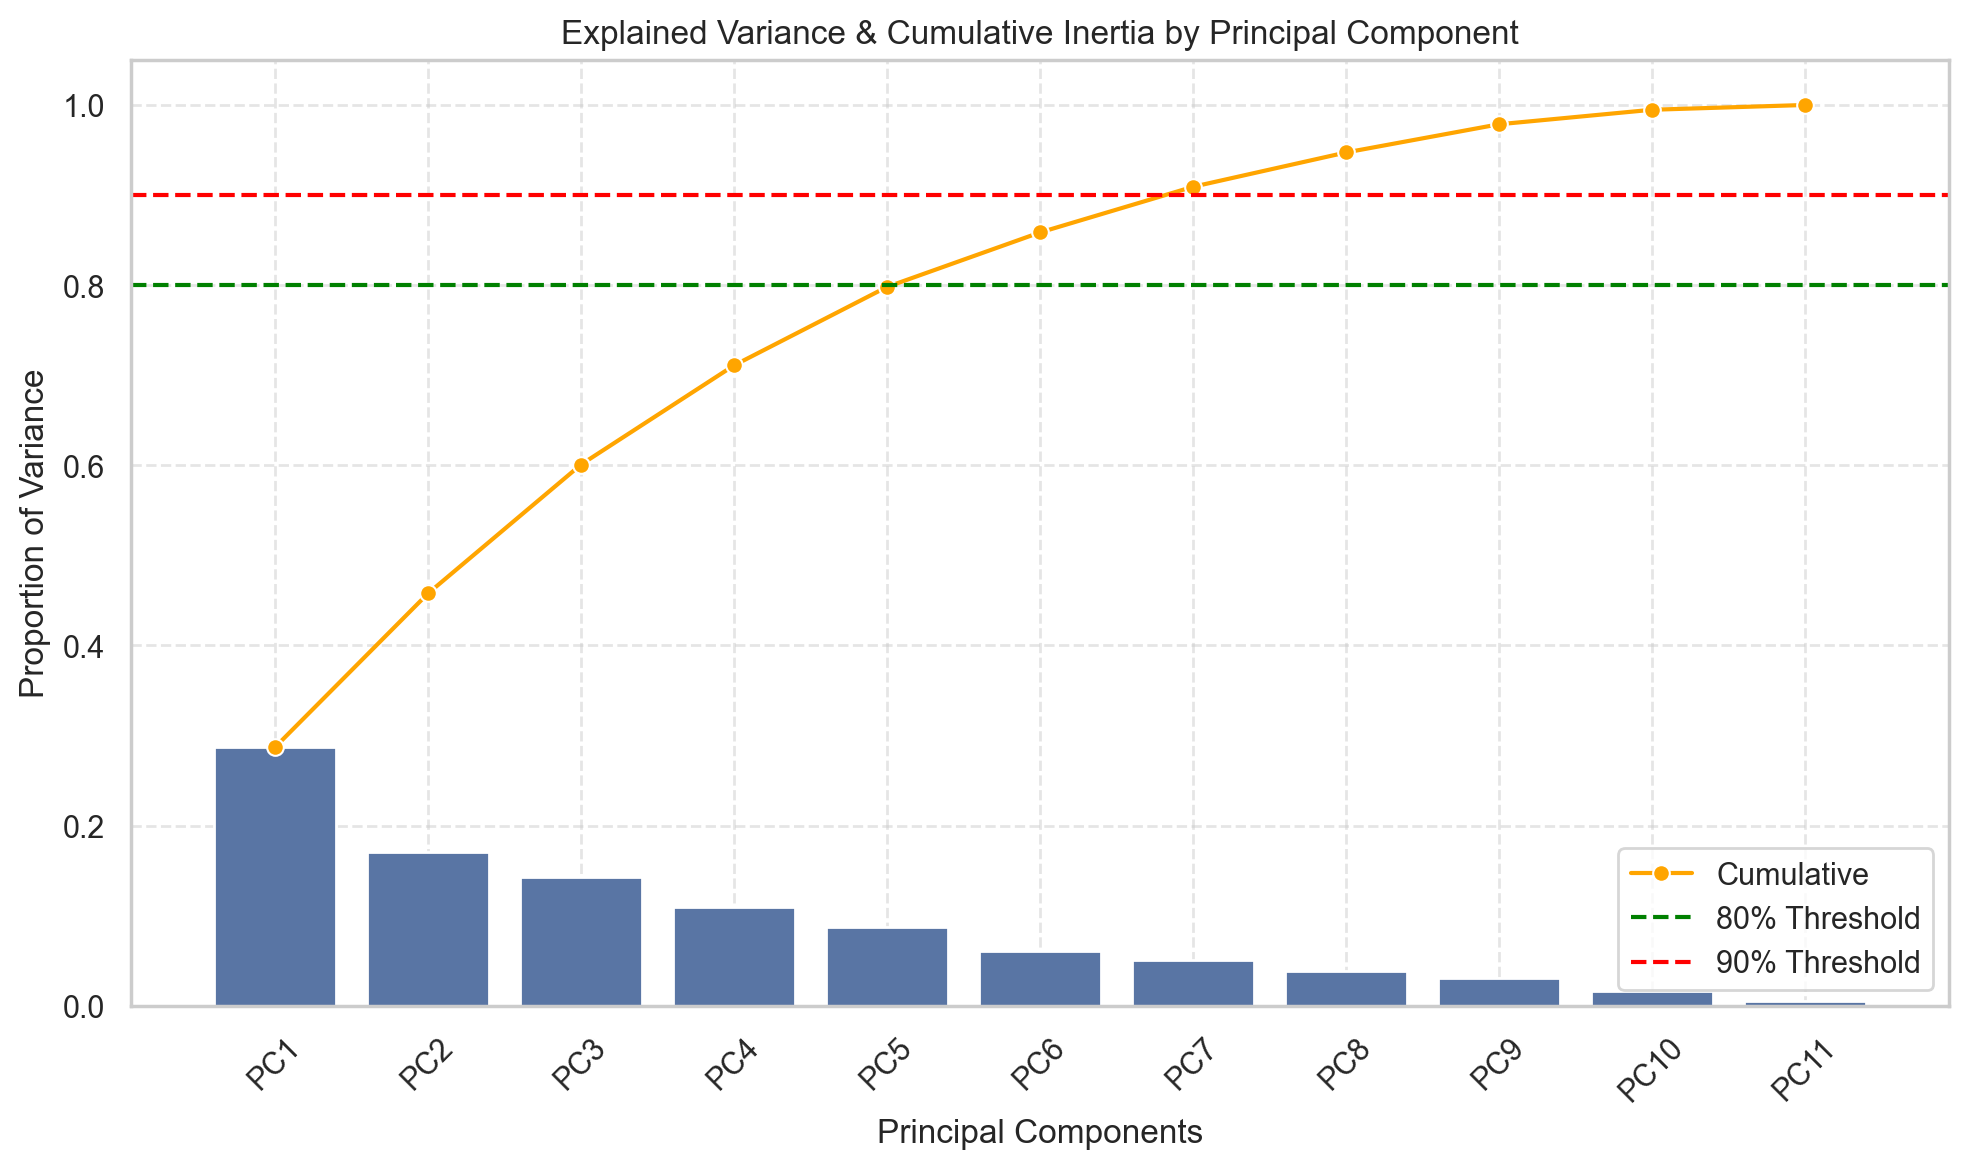

In [27]:
# %% 4.4 PCA and explained variance plot

def plot_pca_variance(
    data: pd.DataFrame, features: List[str]
) -> PCA:
    """
    Fit PCA on the given features and plot both the individual
    explained variance ratios and their cumulative sum.
    """
    X: np.ndarray = data[features].values
    pca_model: PCA = PCA()
    pca_model.fit(X)

    ratios: np.ndarray = pca_model.explained_variance_ratio_
    cum_ratios: np.ndarray = np.cumsum(ratios)
    pcs: List[str] = [f"PC{i+1}" for i in range(len(ratios))]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=pcs, y=ratios)
    sns.lineplot(
        x=list(range(len(cum_ratios))),
        y=cum_ratios,
        marker="o",
        label="Cumulative",
        color="orange"
    )
    plt.axhline(0.80, linestyle="--", label="80% Threshold", color="green")
    plt.axhline(0.90, linestyle="--", label="90% Threshold", color="red")
    plt.title("Explained Variance & Cumulative Inertia by Principal Component")
    plt.xlabel("Principal Components")
    plt.ylabel("Proportion of Variance")
    plt.xticks(rotation=45)
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


# Execute PCA plot
pca_model = plot_pca_variance(df, continuous_features)

### 4.5 Clustering: Elbow Method & Ward’s Hierarchical Clustering

We explore natural groupings in the feature space without using `quality`.

1. **K-means & Elbow Method**  
   Minimize within-cluster inertia  
   $$
     \min_{C_1,\dots,C_K}\sum_{k=1}^K\sum_{x_i\in C_k}\|x_i - \mu_k\|^2.
   $$

2. **Ward’s Method (Agglomerative)**  
   Merge clusters to minimize increase in total within-cluster variance.

We inspect both to decide on a reasonable $K$ for unsupervised segmentation.


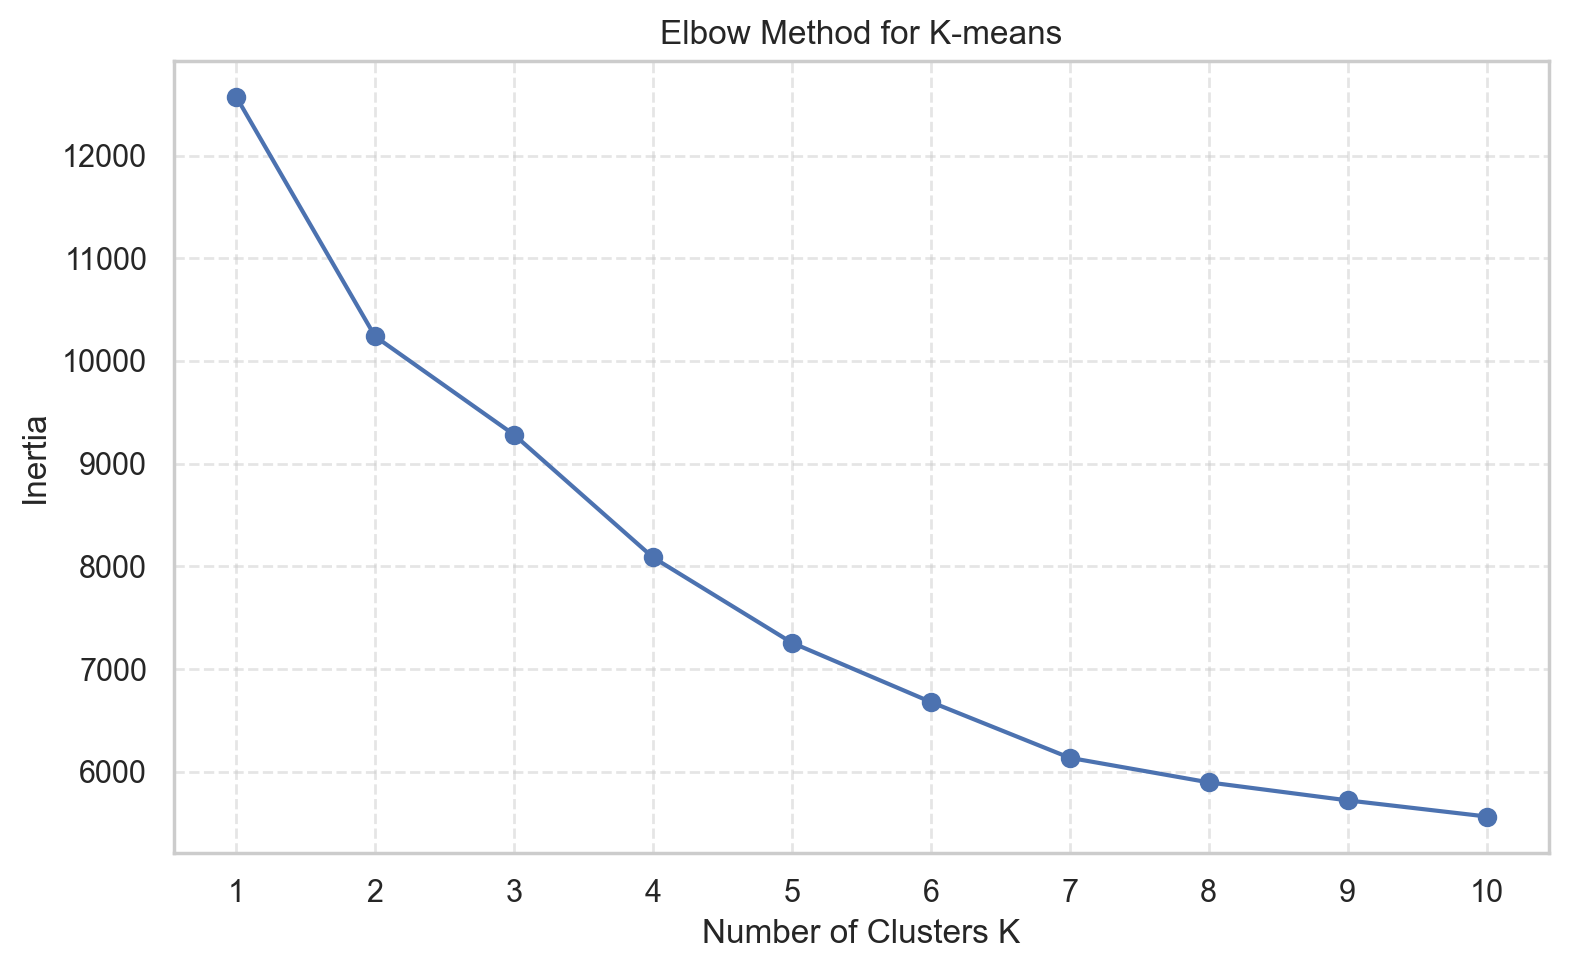

In [28]:
# %% 4.5.1 Elbow method for K-means
def plot_elbow_method(
    data: np.ndarray, max_clusters: int = 10
) -> None:
    """
    Compute K-means inertia for K=1..max_clusters and plot the elbow curve.
    """
    inertias: List[float] = []
    for k in range(1, max_clusters + 1):
        model: KMeans = KMeans(n_clusters=k, random_state=42)
        model.fit(data)
        inertias.append(model.inertia_)
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_clusters + 1), inertias, marker="o")
    plt.title("Elbow Method for K-means")
    plt.xlabel("Number of Clusters K")
    plt.ylabel("Inertia")
    plt.xticks(range(1, max_clusters + 1))
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


# Use normalized continuous features
array_data: np.ndarray = df[continuous_features].values
plot_elbow_method(array_data, max_clusters=10)

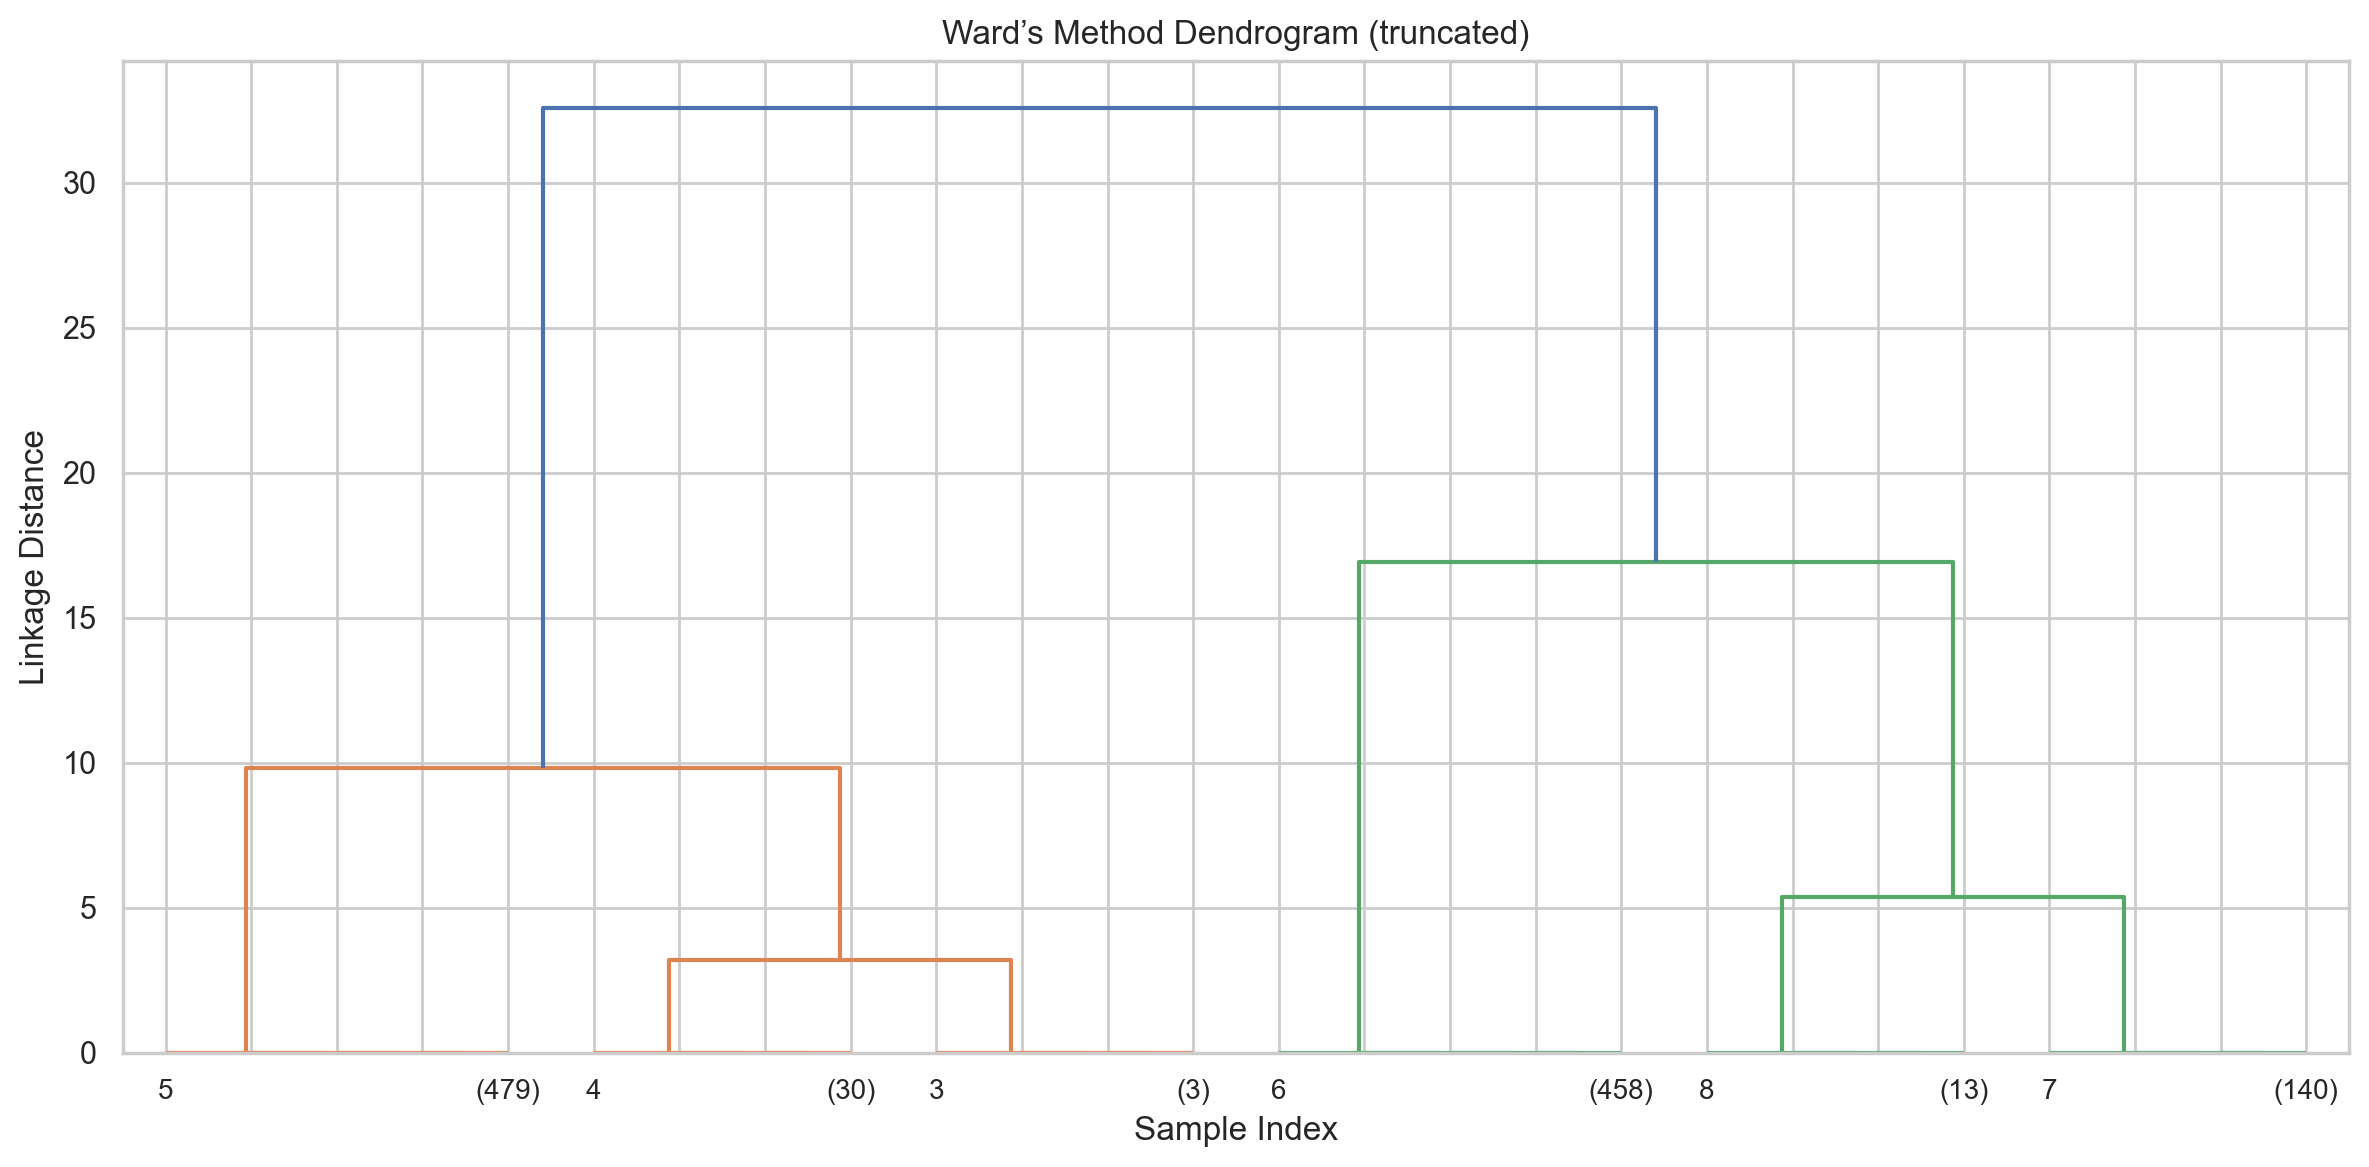

In [29]:
# %% 4.5.2 Ward's hierarchical clustering dendrogram

def plot_ward_dendrogram(data: pd.DataFrame, column: str, truncate: int = 5) -> None:
    """
    Perform Ward's linkage and plot a truncated dendrogram.

    Enhanced to generate labels that show only one label per group.
    """
    # Ensure the specified column exists in the DataFrame
    if column not in data.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame.")

    # Use AgglomerativeClustering to perform hierarchical clustering
    cls = AgglomerativeClustering(
        metric="euclidean", linkage="ward", distance_threshold=0, n_clusters=None
    )
    cls.fit(data[column].to_frame())

    # Generate the linkage matrix
    Z: np.ndarray = linkage(data[column].to_frame(), method="ward")

    plt.figure(figsize=(12, 6))

    # Generate labels: only one displayed per group
    labels_raw = data[column].values
    labels_custom = [""] * len(labels_raw)

    # Keep the first occurrence of each value
    last_indices = {}
    for i in range(len(labels_raw) - 1, -1, -1):
        val = labels_raw[i]
        if val not in last_indices:
            last_indices[val] = i
            labels_custom[i] = str(val)

    # Plot the dendrogram with custom labels
    dendrogram(
        Z,
        truncate_mode="level",
        p=truncate,
        labels=labels_custom,
    )  # Pass custom labels to dendrogram

    plt.title("Ward’s Method Dendrogram (truncated)")
    plt.xlabel("Sample Index")
    plt.ylabel("Linkage Distance")
    # Ensure x-axis labels are vertical
    plt.tick_params(axis="x", labelrotation=0)
    plt.tight_layout()
    plt.show()


plot_ward_dendrogram(df, "quality", truncate=5)

## 5. Problem Definition

In this section we define our supervised learning tasks and prepare the data for modeling.

### 5.1 Target Variable Grouping Strategies

To define the target variable for supervised learning, we consider three grouping strategies for the `quality` variable:

- **6-Class Modeling (Original)**:  
  The `quality` variable remains unchanged, with values ranging from 3 to 8. This approach preserves the full granularity of the data, allowing for detailed predictions. However, it complicates supervised learning due to the sparsity of classes.

- **3-Class Modeling (Ternary)**:  
  Classes are defined using empirical quantiles, resulting in three groups:  
  - **Low**: 3-4-5  
  - **Medium**: 6  
  - **High**: 7-8  
  This reduces class imbalance but diminishes the interpretability of the middle class, which corresponds to a score of 6/10.

- **2-Class Modeling (Binary)**:  
  The values are split into two balanced and meaningful classes:  
  - **Low**: `quality < 6`  
  - **High**: `quality ≥ 6`  
  This simplifies supervised learning and improves efficiency, but sacrifices finer distinctions between "good" and "excellent" wines.

In [30]:
# %% 5.1 Generate and compare target groupings

# 1. Binary
df["y_bin"] = (df["quality"] >= 6).astype(int)

# 2. Ternary


def quality_to_3class(q: int) -> int:
    if q <= 5:
        return 0
    if q == 6:
        return 1
    return 2


df["y_3class"] = df["quality"].apply(quality_to_3class)

# 3. Original
df["y_orig"] = df["quality"]  # unchanged

# Display distributions
for name in ["y_bin", "y_3class", "y_orig"]:
    counts: Counter[Any] = Counter(df[name])
    total: int = len(df)
    print(f"\nDistribution for {name}:")
    for cls, cnt in sorted(counts.items()):
        print(f"  Class {cls}: {cnt} ({cnt/total*100:.1f}%)")


Distribution for y_bin:
  Class 0: 522 (45.7%)
  Class 1: 621 (54.3%)

Distribution for y_3class:
  Class 0: 522 (45.7%)
  Class 1: 462 (40.4%)
  Class 2: 159 (13.9%)

Distribution for y_orig:
  Class 3: 6 (0.5%)
  Class 4: 33 (2.9%)
  Class 5: 483 (42.3%)
  Class 6: 462 (40.4%)
  Class 7: 143 (12.5%)
  Class 8: 16 (1.4%)


**Reflection**

- **6-Class Modeling** preserves nuance but requires handling sparse classes, which can be challenging for some models.  
- **3-Class Modeling** balances the distribution better but risks losing the interpretability of the middle class.  
- **2-Class Modeling** is the simplest and most efficient approach, making it ideal for clear decision boundaries, though it loses granularity.

Several strategies were used to refine these modeling approaches, including the elbow method, Ward's method, the silhouette score, and the empirical cumulative distribution function (ECDF). Ultimately, the binary classification option appears to be the most suitable choice.

Based on these trade-offs, we will proceed with **binary classification** for simplicity and efficiency, while also setting up the **ternary scenario** as an extension for more nuanced analysis.

### 5.2 Defining the Supervised Task

First, we inspect the distribution of the original `quality` scores (0–10) to decide whether to pursue regression, classification, or both. If we choose binary classification, we create a new target variable:

$$
y_{\text{bin}} = 
\begin{cases}
1, & \text{if } \text{quality} \ge 6,\\
0, & \text{otherwise}.
\end{cases}
$$

We also display class proportions to check for imbalance.



In [31]:
# %% 5.1 Define binary target variable and inspect distribution

# Create binary target: 1 if quality >= 6, else 0
threshold: int = 6
df["target_class"] = (df["quality"] >= threshold).astype(int)

# Inspect distribution
class_counts: Counter[int] = Counter(df["target_class"])
total_samples: int = len(df)
print("Class distribution (binary):")
for cls, count in class_counts.items():
    pct: float = count / total_samples * 100
    print(f"  Class {cls}: {count} samples ({pct:.1f}%)")

Class distribution (binary):
  Class 0: 522 samples (45.7%)
  Class 1: 621 samples (54.3%)


### 5.2 Splitting into Train and Test Sets

We split the data into training and testing subsets to fairly evaluate our models:

- Let $\mathbf{X}$ be the matrix of features and $\mathbf{y}$ the target vector.
- We use an 80/20 split:
  $$
  (\mathbf{X}_{\text{train}}, \mathbf{X}_{\text{test}}, \mathbf{y}_{\text{train}}, \mathbf{y}_{\text{test}})
  = \mathrm{train\_test\_split}(\mathbf{X}, \mathbf{y}, \text{test\_size}=0.2,\ \text{random\_state}=42).
  $$

This ensures reproducibility and a held-out set for final evaluation.

In [32]:
# %% 5.2 Split into training and test sets

def split_dataset(
    df: pd.DataFrame,
    feature_cols: List[str],
    target_col: str,
    test_size: float = 0.2,
    random_state: int = 42
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Split features and target into train/test sets.

    Parameters:
        df (pd.DataFrame): Full dataset.
        feature_cols (List[str]): Names of feature columns.
        target_col (str): Name of target column.
        test_size (float): Proportion for test set.
        random_state (int): Seed for reproducibility.

    Returns:
        Tuple containing X_train, X_test, y_train, y_test.
    """
    X: pd.DataFrame = df[feature_cols]
    y: pd.Series = df[target_col]
    return train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )


# Select feature columns (continuous features defined earlier)
feature_cols: List[str] = continuous_features

# Perform split
X_train, X_test, y_train, y_test = split_dataset(
    df, feature_cols, "target_class", test_size=0.2
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set:     {X_test.shape[0]} samples")

Training set: 914 samples
Test set:     229 samples


## 6. Summary & Next Steps

### 6.1 Summary of Steps Completed  
- **Data loading & typing**: we defined a strict schema (`TypedDict`) and loaded the CSV with proper `snake_case` column names and exact dtypes.  
- **Cleaning & preprocessing**: duplicates were removed, missing values imputed by column‐wise medians, and all continuous features normalized to z‐scores.  
- **Exploratory Data Analysis**:
  - **Univariate**: distributions (histograms, boxplots) and summary statistics highlighted skewness in `residual_sugar` and `free_sulfur_dioxide`.  
  - **Bivariate**: Pearson correlations identified top drivers of quality; ECDFs revealed percentile structure; PCA showed that 5 components capture ≥ 80 % of variance.  
  - **Clustering**: elbow method and Ward’s dendrogram suggested 3–4 natural clusters in the physicochemical space.  
- **Target grouping reflection**: we compared binary, ternary, and original 11‐class schemes, weighing accuracy vs. granularity and class balance.

### 6.2 Decision: Regression Formulation  
Given our dual questions—
1. *How to predict the numerical quality of a wine?*  
2. *What physicochemical properties make a “good” wine?*  

—and the fine‐grained nature of the original 0–10 scale, we will frame our task as **regression** on the continuous `quality` score. This preserves nuance and enables direct error metrics (e.g., RMSE).

### 6.3 Next Steps  
In the upcoming notebooks we will split the workflow into two parallel threads:

1. **Notebook 2: Regression Modeling**  
   - Define feature matrix $\mathbf{X}$ and target vector $\mathbf{y}=\text{quality}$.  
   - Establish a modeling pipeline with scaling, optional dimensionality reduction (PCA), and regressor (e.g., Linear Regression, Ridge, Random Forest).  
   - Use cross‐validation to compare models via RMSE, $R^2$, and residual diagnostics.  
2. **Notebook 3: Domain Insights & “What Makes a Good Wine”**  
   - Analyze model coefficients and feature importances.  
   - Interpret principal components in chemical terms.  
   - Suggest actionable physicochemical profiles for “excellent” wines.

### 6.4 Save Processed Data  
We save the fully preprocessed dataset for downstream modeling.


In [33]:
# %% 6.4 Save processed dataset

PROCESSED_DATA_PATH: Final[str] = os.path.join(
    os.path.dirname(os.getcwd()), "data", "wine_quality_processed.csv"
)

df.to_csv(PROCESSED_DATA_PATH, index=False)
print(f"Processed dataset saved to {PROCESSED_DATA_PATH}")

Processed dataset saved to c:\Users\pierr\Code\Python\wine-quality\data\wine_quality_processed.csv
